In [1]:
from collections import defaultdict
from typing import List, Dict, Tuple
import torch
from src.utils import helpers
from model_activations import ModelActivations
import utils
from utils import make_batch_input
import pickle
from interpretable_impala import CustomCNN
import pickle
import os, numpy as np
from src.utils.steering_experiments import steering_vector
import seaborn as sns



In [2]:
import random
from src.utils import heist
def convert_to_list(vector):
    return [vector[i] for i in range(vector.shape[0])]

def get_colors(to_check_env, entity_name):
    if entity_name == "key":
        colors = to_check_env.get_key_colors()
    elif entity_name =="lock":
        colors = to_check_env.get_lock_colors()
    return colors
    
def get_venvs_objective_steering(entity_name, entity_color, size):
    venvs = []  
    i=0
    while i < size:
        start_level = random.randint(100000, 100000000)

        venv = heist.create_venv(num=1, num_levels=0, start_level=start_level)
        state = heist.state_from_venv(venv, 0)
        state_bytes = state.state_bytes
        to_check_env = heist.EnvState(state_bytes)
        colors = get_colors(to_check_env,entity_name)
        if entity_color in colors:
            venvs.append(venv)
            i+= 1
        else:
            continue
        
    return venvs

def get_venvs_gem_steering(size):
    venvs = []  
    i=0
    while i < size:
        start_level = random.randint(100000, 100000000)
        venv = heist.create_venv(num=1, num_levels=0, start_level=start_level)
        venvs.append(venv)
        
    return venvs


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import math


def visualize_matrices(matrices, plot_type='line'):
    """
    Visualizes a list of matrices by flattening them and plotting them on the same graph.
    
    Parameters:
    matrices (list of np.ndarray): List of matrices of the same size.
    plot_type (str): Type of plot to use ('line', 'bar', 'scatter', or 'heatmap').
    """
    # Check if the list is empty
    if not matrices:
        print("The list of matrices is empty.")
        return

    # Flatten each matrix in the list
    flattened_matrices = [matrix.flatten() for matrix in matrices]

    # Define colors and markers for the plots
    colors = ['blue', 'green', 'red', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']
    markers = ['o', 's', '^', 'D', 'P', '*', 'X', 'v', '<', '>']
    
    indices = np.arange(len(flattened_matrices[0]))  # Indices for plotting

    plt.figure(figsize=(10, 6))

    if plot_type == 'line':
        for i, flattened_matrix in enumerate(flattened_matrices):
            plt.plot(indices, flattened_matrix, marker=markers[i % len(markers)], 
                     color=colors[i % len(colors)], label=f'Matrix {i+1}')
        plt.xlabel("Index")
        plt.ylabel("Value")
        plt.title("Line Plot of Flattened Matrices")
        plt.legend()

    elif plot_type == 'bar':
        width = 0.8 / len(flattened_matrices)  # Width of bars depending on the number of matrices
        for i, flattened_matrix in enumerate(flattened_matrices):
            plt.bar(indices + i * width, flattened_matrix, width=width, 
                    color=colors[i % len(colors)], label=f'Matrix {i+1}')
        plt.xlabel("Index")
        plt.ylabel("Value")
        plt.title("Bar Plot of Flattened Matrices")
        plt.legend()

    elif plot_type == 'scatter':
        for i, flattened_matrix in enumerate(flattened_matrices):
            plt.scatter(indices, flattened_matrix, marker=markers[i % len(markers)], 
                        color=colors[i % len(colors)], label=f'Matrix {i+1}')
        plt.xlabel("Index")
        plt.ylabel("Value")
        plt.title("Scatter Plot of Flattened Matrices")
        plt.legend()

    elif plot_type == 'heatmap':
        # Stack the flattened matrices vertically to create a 2D array
        all_matrices = np.vstack(flattened_matrices)
        import seaborn as sns
        sns.heatmap(all_matrices, annot=True, cmap='coolwarm', cbar=True, 
                    yticklabels=[f'Channel {i+1}' for i in range(len(matrices))])
        plt.title("Heatmap of Flattened Channels Layer: Pool4")

    else:
        print("Invalid plot type. Choose from 'line', 'bar', 'scatter', or 'heatmap'.")
        return

    plt.show()

def visualize_heatmap(matrices):
    # Flatten each matrix in the list
    flattened_matrices = np.vstack([matrix.flatten() for matrix in matrices])

    # Create a heatmap
    sns.heatmap(flattened_matrices, annot=False, cmap='coolwarm', cbar=True, 
                yticklabels=[f'Channel {i}' for i in range(len(matrices))])
    plt.title("Heatmap of Flattened Channels in Pool 4")
    plt.xlabel("Flattened Indices (pixels)")
    plt.ylabel("Channel")
    plt.show()

def find_largest_entry(matrices, position):
    # Flatten each matrix and stack them vertically
    flattened_matrices = np.vstack([matrix.flatten() for matrix in matrices])
    
    # Find the maximum value in the flattened matrix array
    max_value = np.max(flattened_matrices)
    
    # Get the index of the maximum value in the flattened version
    # which will be a single integer reflecting the position in the stacked array
    max_index_flat = np.argmax(flattened_matrices)
    
    # Determine which matrix this index corresponds to
    num_cols = flattened_matrices.shape[1]  # number of columns in the flattened array
    matrix_index = max_index_flat // num_cols  # integer division to find the matrix number
    within_matrix_index = max_index_flat % num_cols  # remainder to find index within the matrix
    x, y = position
    if not math.isnan(x) and not math.isnan(y):
        calculate_position = math.floor(x/2.25) + 4* math.floor((9-y)/2.25)
        if within_matrix_index in range(calculate_position -1, calculate_position+2):
            return matrix_index+1, within_matrix_index, max_value
 
    return -1, -1, -1

def find_positive_activations(matrices, position):
    """
    Find matrices with positive activations greater than 0.1 within a specified range.
    """
    results = []

    # Assuming position is already defined somewhere correctly as x, y
    x, y = position  # uncomment this if position needs to be passed and used
    flattened_matrices = [matrix.flatten() for matrix in matrices]
    activation_width = math.sqrt(len(flattened_matrices[0]))  # Assuming square matrices
    ratio = 9 / activation_width
    print("activation width:", activation_width)
    print("ratio:", ratio)

    # Check for NaNs if x, y are involved here, assuming position handling is needed
    if not math.isnan(x) and not math.isnan(y):
        calculate_position = int(math.floor(x / ratio) + activation_width * math.floor((9 - y) / ratio))

        for i, flattened_matrix in enumerate(flattened_matrices):
            # Define the range to check around the calculated position
            start_index = max(0, calculate_position - 1)  # Ensure it doesn't go below zero
            end_index = min(len(flattened_matrix), calculate_position + 2)  # +2 to include 'calculate_position+1'
            
            # Extract the segment to check
            segment = flattened_matrix[start_index:end_index]
            
            # Check if any value within the range is greater than 0.1 using Python's any()
            if any(abs(value) > 0 for value in segment):
                max_value = max(segment)
                results.append((i, max_value))

    return results

def find_largest_entry_all_layers(matrices, position):

    # Flatten each matrix and stack them vertically
    flattened_matrices = np.vstack([matrix.flatten() for matrix in matrices])
    activation_width = math.sqrt(flattened_matrices.shape[1])
    ratio = 9/activation_width

    
    # Find the maximum value in the flattened matrix array
    max_value = np.max(flattened_matrices)
    
    # Get the index of the maximum value in the flattened version
    # which will be a single integer reflecting the position in the stacked array
    max_index_flat = np.argmax(flattened_matrices)
    
    # Determine which matrix this index corresponds to
    num_cols = flattened_matrices.shape[1]  # number of columns in the flattened array
    matrix_index = max_index_flat // num_cols  # integer division to find the matrix number
    within_matrix_index = max_index_flat % num_cols  # remainder to find index within the matrix
    x, y = position
    if not math.isnan(x) and not math.isnan(y):
        calculate_position = math.floor(x/ratio) + activation_width* math.floor((9-y)/ratio)
        if within_matrix_index in range(int(calculate_position - ((activation_width/4))), int(calculate_position+((activation_width/4)) +1)):
            return matrix_index, within_matrix_index, max_value
 
    return -1, -1, -1
def find_smallest_entry_all_layers(matrices, position):

    # Flatten each matrix and stack them vertically
    flattened_matrices = np.vstack([matrix.flatten() for matrix in matrices])
    activation_width = math.sqrt(flattened_matrices.shape[1])
    ratio = 9/activation_width
    
    # Find the maximum value in the flattened matrix array
    min_value = np.min(flattened_matrices)
   
    # Get the index of the maximum value in the flattened version
    # which will be a single integer reflecting the position in the stacked array
    min_index_flat = np.argmin(flattened_matrices)
   
    # Determine which matrix this index corresponds to
    num_cols = flattened_matrices.shape[1]  # number of columns in the flattened array
    matrix_index = min_index_flat // num_cols  # integer division to find the matrix number
    within_matrix_index = min_index_flat % num_cols  # remainder to find index within the matrix

    x, y = position
    if not math.isnan(x) and not math.isnan(y):
        calculate_position = math.floor(x/ratio) + activation_width* math.floor((9-y)/ratio)
        if within_matrix_index in range(int(calculate_position - ((activation_width/4))), int(calculate_position+((activation_width/4)) +1)):
            if min_value < 0:
                return matrix_index, within_matrix_index, min_value
 
    return -1, -1, -1

def find_smallest_entry_not_at_goal(matrices, position):

    # Flatten each matrix and stack them vertically
    flattened_matrices = np.vstack([matrix.flatten() for matrix in matrices])
  
    # Find the maximum value in the flattened matrix array
    min_value = np.min(flattened_matrices)

    # Get the index of the maximum value in the flattened version
    # which will be a single integer reflecting the position in the stacked array
    min_index_flat = np.argmin(flattened_matrices)

    # Determine which matrix this index corresponds to
    num_cols = flattened_matrices.shape[1]  # number of columns in the flattened array
    matrix_index = min_index_flat // num_cols  # integer division to find the matrix number
    within_matrix_index = min_index_flat % num_cols  # remainder to find index within the matrix


    if min_value < -0.1:
        return matrix_index, within_matrix_index, min_value

    return -1, -1, -1

def find_largest_entry_not_at_goal(matrices, position):

    # Flatten each matrix and stack them vertically
    flattened_matrices = np.vstack([matrix.flatten() for matrix in matrices])

    
    # Find the maximum value in the flattened matrix array
    max_value = np.max(flattened_matrices)

    # Get the index of the maximum value in the flattened version
    # which will be a single integer reflecting the position in the stacked array
    max_index_flat = np.argmax(flattened_matrices)

    # Determine which matrix this index corresponds to
    num_cols = flattened_matrices.shape[1]  # number of columns in the flattened array
    matrix_index = max_index_flat // num_cols  # integer division to find the matrix number
    within_matrix_index = max_index_flat % num_cols  # remainder to find index within the matrix

    return matrix_index, within_matrix_index, max_value


def find_smallest_entry_all_layers_positively_activating_blue_key(matrices, position, blue_key_position):

    # Flatten each matrix and stack them vertically
    flattened_matrices = np.vstack([matrix.flatten() for matrix in matrices])
    activation_width = math.sqrt(flattened_matrices.shape[1])

    ratio = 9/activation_width

    
    # Find the maximum value in the flattened matrix array
    min_value = np.min(flattened_matrices)

    
    # Get the index of the maximum value in the flattened version
    # which will be a single integer reflecting the position in the stacked array
    min_index_flat = np.argmin(flattened_matrices)


    
    # Determine which matrix this index corresponds to
    num_cols = flattened_matrices.shape[1]  # number of columns in the flattened array
    matrix_index = min_index_flat // num_cols  # integer division to find the matrix number
    within_matrix_index = min_index_flat % num_cols  # remainder to find index within the matrix

    x, y = position
    x_blue, y_blue = blue_key_position
    if not math.isnan(x) and not math.isnan(y) and not math.isnan(x_blue) and not math.isnan(y_blue):
        calculate_position = math.floor(x/ratio) + activation_width* math.floor((9-y)/ratio)
        calculate_blue_position = math.floor(x_blue/ratio) + activation_width* math.floor((9-y_blue)/ratio)
        start = max(0,int(calculate_blue_position - (activation_width/4)))
        end = min(int(calculate_blue_position + (activation_width/4) + 1), len(flattened_matrices[0]))
        if within_matrix_index in range(int(calculate_position - (activation_width/4)), int(calculate_position+(activation_width/4) +1)):
            if min_value < -0.1:

                blue_key_activations = np.max(flattened_matrices[matrix_index][start:end])
                if blue_key_activations > 0 and blue_key_activations > 0.1:
                    return matrix_index,  blue_key_activations, min_value
 
    return -1, -1, -1


def plot_pca_2d(matrices):
    """
    Performs PCA on flattened matrices and plots the first two components in 2D space.

    Parameters:
    matrices (list of np.ndarray): List of 2D matrices to be flattened and analyzed.
    """

    # Step 1: Flatten the matrices
    flattened_matrices = np.array([matrix.flatten() for matrix in matrices])

    # Step 2: Apply PCA to reduce the dimensionality to 2 components
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(flattened_matrices)

    # Step 3: Plot the PCA result in 2D space
    plt.figure(figsize=(8, 6))

    # Scatter plot with PCA results
    scatter = plt.scatter(pca_result[:, 0], pca_result[:, 1], 
                          c=range(len(matrices)), cmap='viridis', s=100)

    # Annotate the points with matrix labels
    for i in range(len(matrices)):
        plt.text(pca_result[i, 0], pca_result[i, 1], 
                 f'Matrix {i+1}', fontsize=10)

    # Set labels and title
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.title('2D PCA of Flattened Matrices')

    # Add color bar to interpret the color mapping
    cbar = plt.colorbar(scatter)
    cbar.set_label('Matrix Index')

    plt.show()



In [5]:

import math
def visualise_activations(activation_tensor,layer_name = "conv1a"):
    num_activations = activation_tensor.shape[0]  # Number of activation maps
            
            # Calculate grid size
    grid_size = math.ceil(math.sqrt(num_activations))

    # Create a figure with dynamic subplots based on the number of activations
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(grid_size * 2, grid_size * 2))
    if grid_size == 1:
        axes = np.array([[axes]])  # Ensure axes can be indexed with two dimensions

    # Initialize an index for activation maps
    activation_idx = 0

    for i in range(grid_size):
        for j in range(grid_size):
            ax = axes[i, j]
            
            # Plot the activation map if we haven't gone through all of them yet
            if activation_idx < num_activations:
                ax.imshow(activation_tensor[activation_idx, :, :], cmap='viridis', aspect='auto')
                ax.set_title(f'Filter {activation_idx+1} {layer_name}', fontsize=8)
                activation_idx += 1
            else:
                ax.axis('off')  # Hide axes without data
            
            ax.axis('off')  # Hide axes for all plots for a cleaner look

    plt.tight_layout()

  
    plt.show()


64 64
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Saved gif!


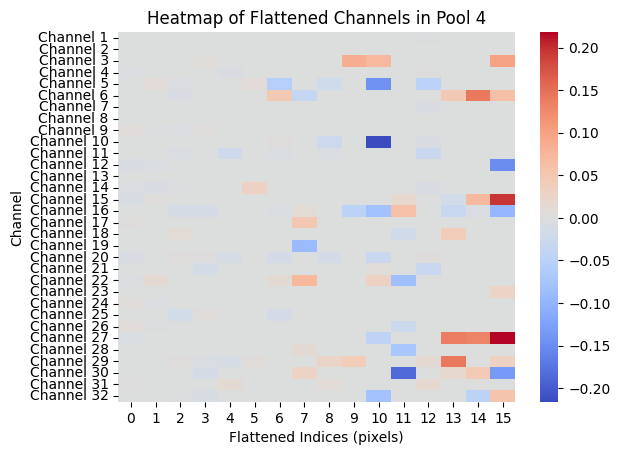

(5.401402950286865, 0.5535290241241455)
64 64
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Saved gif!


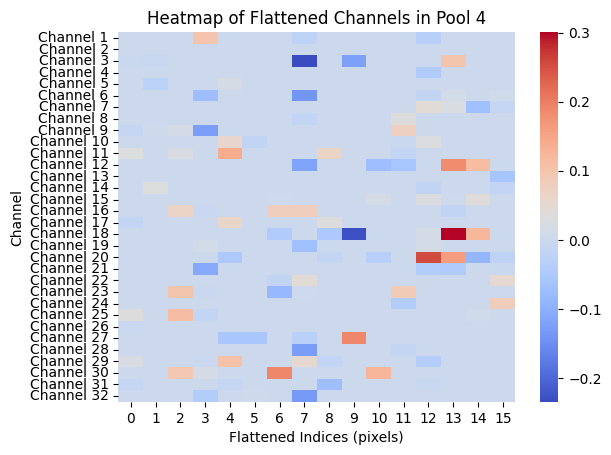

(3.457225799560547, 3.458425760269165)
64 64
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torc

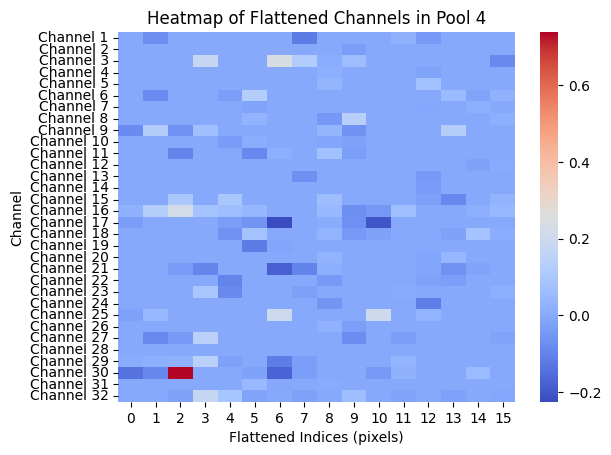

(4.394279956817627, 8.516753196716309)
64 64
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torc

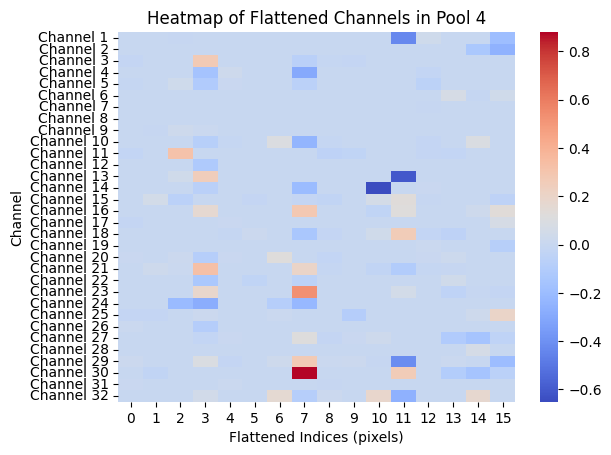

(8.456887245178223, 4.531250953674316)
64 64
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Saved gif!


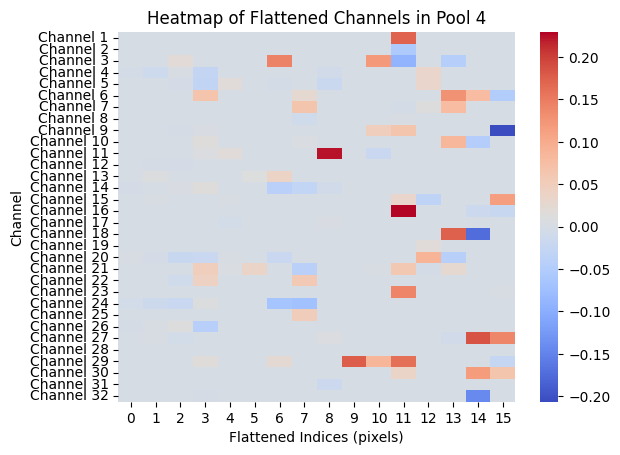

(5.462160587310791, 0.4526750147342682)
64 64
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'tor

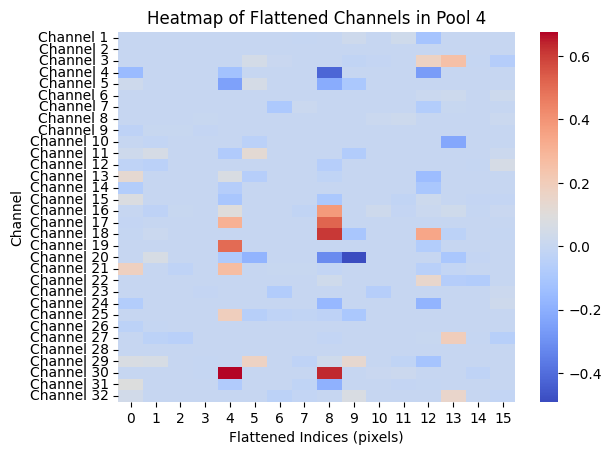

(0.39057910442352295, 4.491321563720703)
64 64
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'to

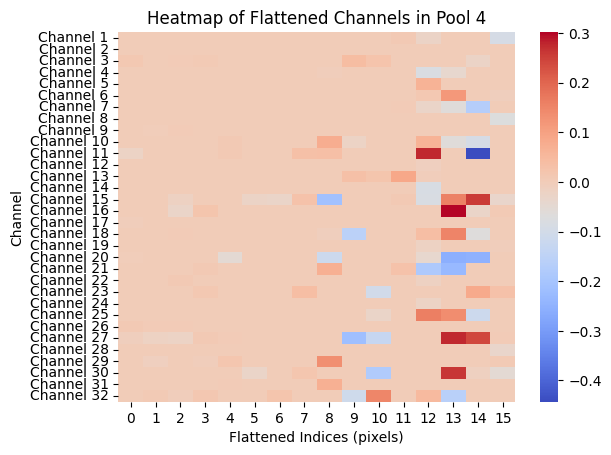

(3.6173107624053955, 1.589979887008667)
64 64
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Saved gif!


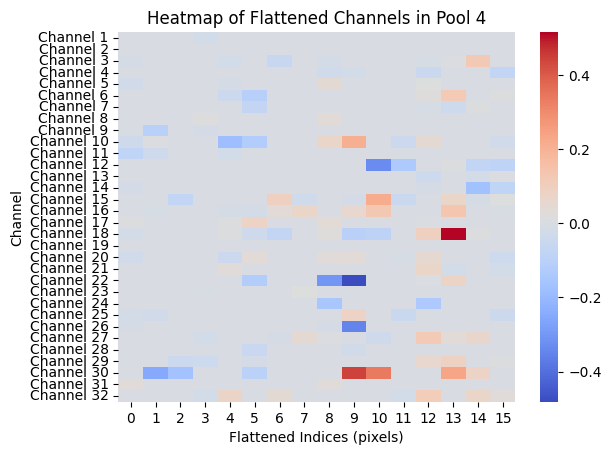

(4.500556945800781, 2.480408191680908)
64 64
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Saved gif!


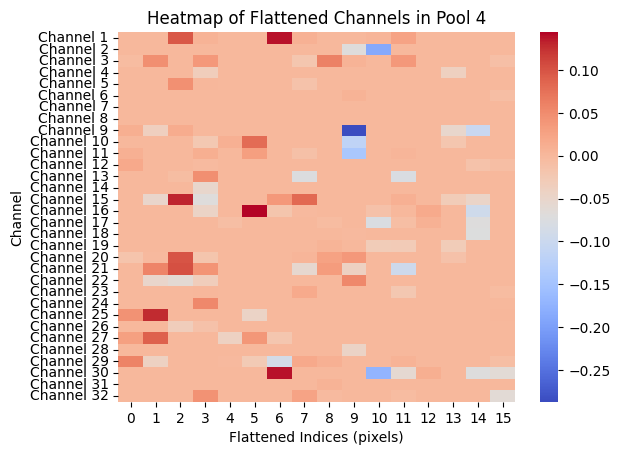

(4.5756940841674805, 5.577658176422119)
64 64
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'tor

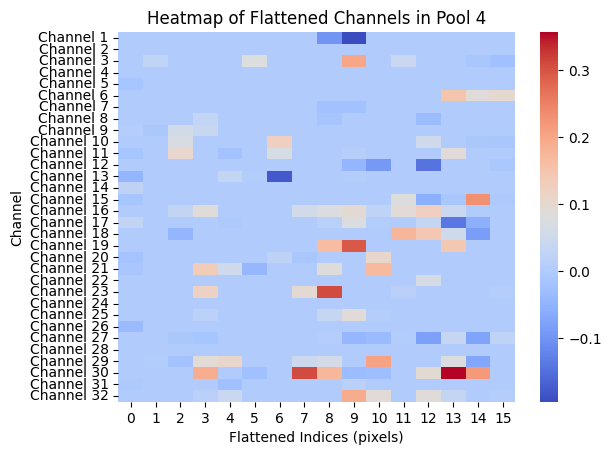

(4.56486177444458, 0.5236644744873047)
64 64
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torc

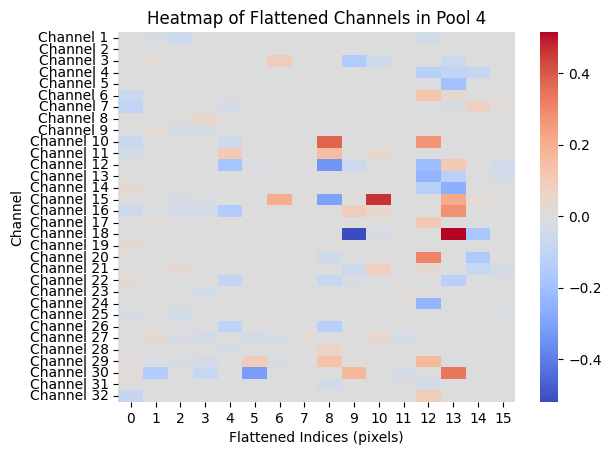

(3.5930280685424805, 2.4592061042785645)
64 64
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Saved gif!


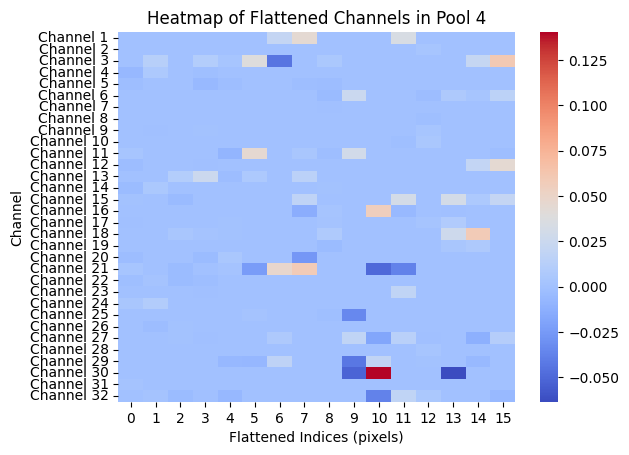

(6.622843265533447, 3.5221617221832275)
64 64
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Saved gif!


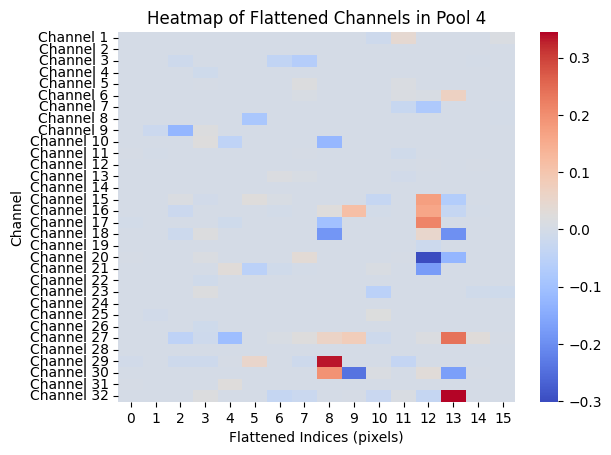

(0.5413092970848083, 2.4278993606567383)
64 64
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'to

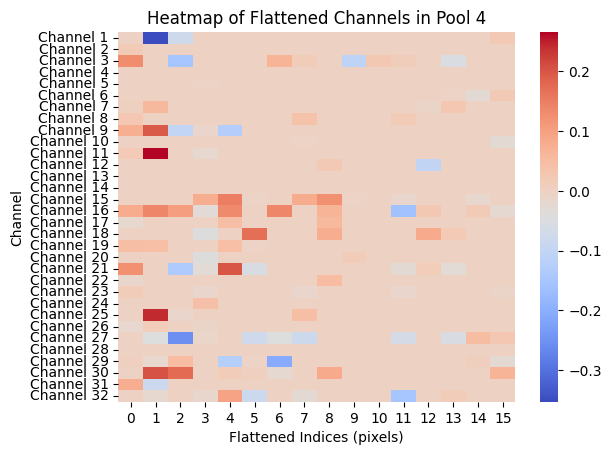

(4.577193260192871, 8.417981147766113)
64 64
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torc

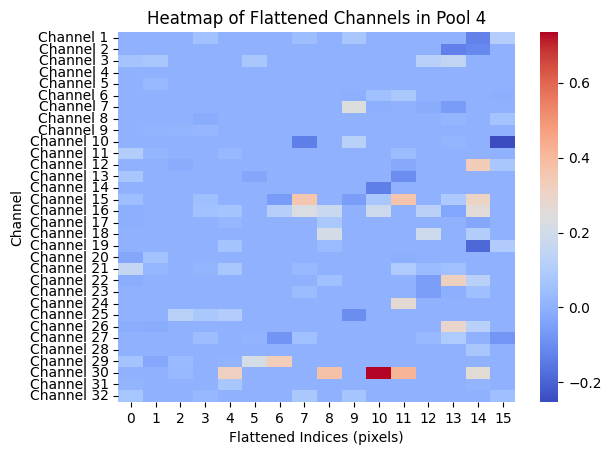

(6.515997886657715, 2.4795846939086914)
64 64
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'tor

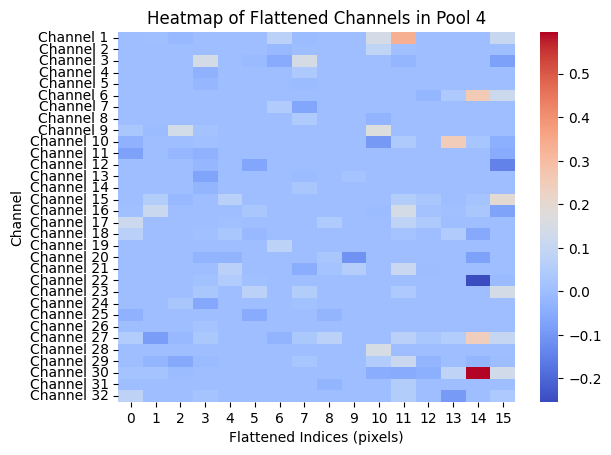

(5.553705215454102, 0.48829683661460876)
64 64
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'to

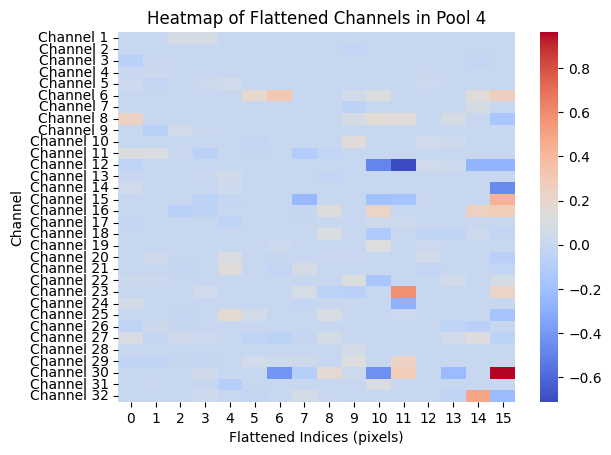

(8.404376029968262, 1.5512555837631226)
64 64
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'tor

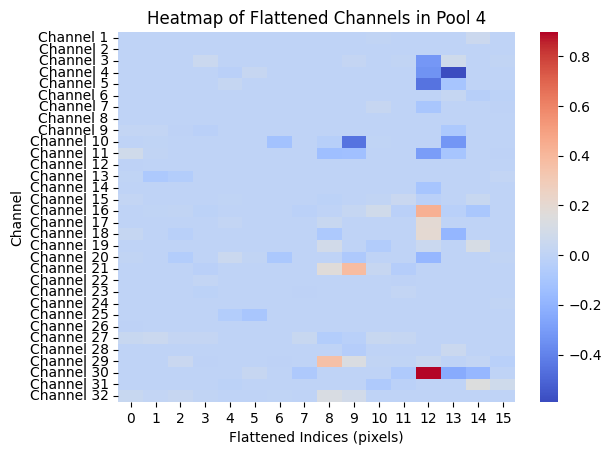

(0.544994592666626, 0.5974128246307373)
64 64
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'tor

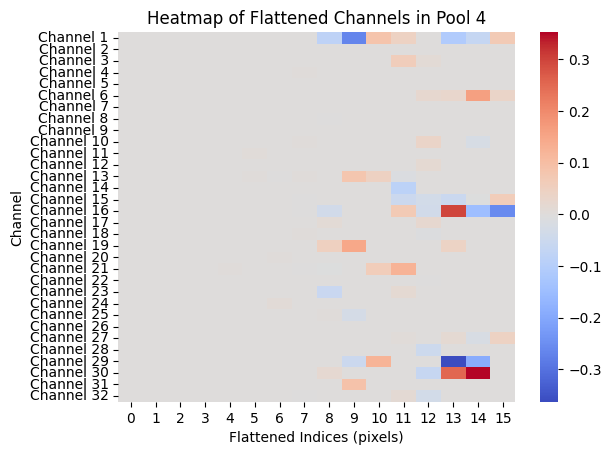

(4.567113876342773, 0.42164140939712524)
64 64
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Saved gif!


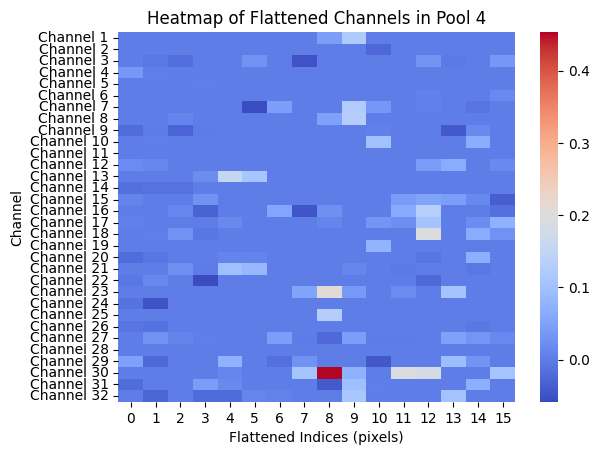

(8.475324630737305, 3.4145514965057373)


In [5]:

from src.utils.steering_experiments import steering_vector
model_path ="model_interpretable.pt"
layer_number = 9
steering_channel = 30
modification_value = -2
episode =200
entity_name = "key"
entity_color = "green"
for i in range(20):
    filepath =f"../gifs/dataset{i}"
    venv = dataset[i]
    stv, original_position = steering_vector(venv= venv,model_path= model_path,entity_name=entity_name,entity_color=entity_color, filepath = filepath, save_gif = "False")
    sv= convert_to_list(stv)
    visualize_heatmap(sv)
    print(original_position)


In [6]:
def print_histogram(title, data, layer_number, objective):
    # Data in the form of a dictionary
    # Keys and values extracted from the dictionary
    ages = list(data.keys())
    frequencies = list(data.values())

    # Plotting the histogram
    plt.figure(figsize=(10, 5))
    plt.bar(ages, frequencies, width=0.6, color='blue')

    # Adding labels and title
    plt.xlabel(f'Channels in {objective} Steering Vector at Layer {layer_number}')
    plt.ylabel(f'Frequency of channel')
    plt.title(title)

    # Setting x-ticks to show every value from 1 to 32
    plt.xticks(range(0, 32))  

    # Show the plot
    plt.show()
import matplotlib.pyplot as plt

def print_dual_histogram(title, data1, data2, layer_number):
    # Extract only the common keys
    common_keys = set(data1.keys()).intersection(data2.keys())
    common_keys = sorted(common_keys)  # Sorting keys to maintain order

    # Extract frequencies for the common keys
    freq1 = [data1[key] for key in common_keys]
    freq2 = [data2[key] for key in common_keys]

    # Set up indices for the x-axis
    ind = range(len(common_keys))  # the x locations for the groups
    width = 0.3  # width of each bar
    ind1 = [x - width/2 for x in ind]  # shift first group to left
    ind2 = [x + width/2 for x in ind]  # shift second group to right

    # Plotting the histograms
    plt.figure(figsize=(12, 6))
    plt.bar(ind1, freq1, width=width, color='blue', label='Channels activating most negatively on green key')
    plt.bar(ind2, freq2, width=width, color='red', label='Channels activating most positively on blue key')

    # Adding labels and title
    plt.xlabel(f'Channels in Steering Vector at Layer {layer_number}')
    plt.ylabel('Frequency of channel')
    plt.title(title)
    plt.xticks(ind, common_keys)  # Set x-ticks to the common keys

    # Adding legend
    plt.legend()

    # Show the plot
    plt.show()


64 64
1
activation width 32.0
ratio 0.28125
range of activations 47 64
64 64
1
activation width 32.0
ratio 0.28125
range of activations 530 547
64 64
1
activation width 32.0
ratio 0.28125
range of activations 840 857
64 64
1
activation width 32.0
ratio 0.28125
range of activations 274 291
64 64
1
activation width 32.0
ratio 0.28125
range of activations 712 729
64 64
1
activation width 32.0
ratio 0.28125
range of activations 719 736
64 64
1
activation width 32.0
ratio 0.28125
range of activations 263 280
64 64
1
activation width 32.0
ratio 0.28125
range of activations 399 416
64 64
1
activation width 32.0
ratio 0.28125
range of activations 982 999
64 64
1
activation width 32.0
ratio 0.28125
range of activations 964 981
64 64
1
activation width 32.0
ratio 0.28125
range of activations 153 170
64 64
1
activation width 32.0
ratio 0.28125
range of activations 943 960
64 64
1
activation width 32.0
ratio 0.28125
range of activations 385 402
64 64
1
activation width 32.0
ratio 0.28125
range of 

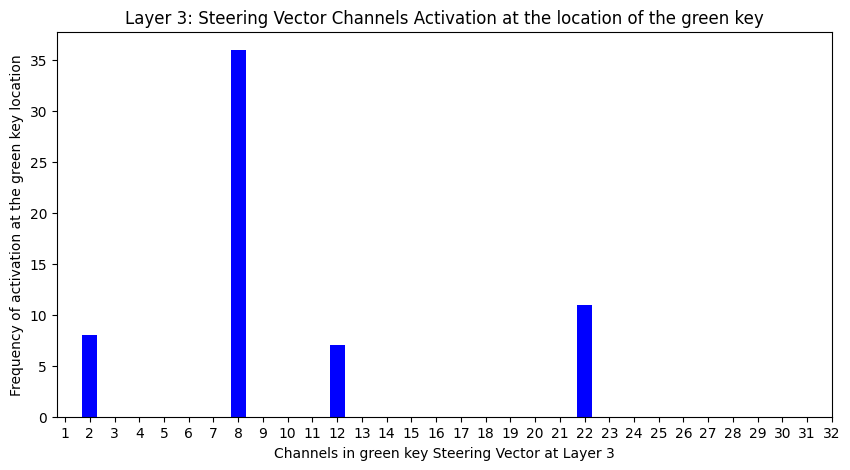

64 64
1
activation width 32.0
ratio 0.28125
range of activations 75 92
64 64
1
activation width 32.0
ratio 0.28125
range of activations 718 735
64 64
1
activation width 32.0
ratio 0.28125
range of activations 68 85
64 64
1
activation width 32.0
ratio 0.28125
range of activations 32 49
64 64
1
activation width 32.0
ratio 0.28125
range of activations 160 177
64 64
1
activation width 32.0
ratio 0.28125
range of activations 480 497
64 64
1
activation width 32.0
ratio 0.28125
range of activations 530 547
64 64
1
activation width 32.0
ratio 0.28125
range of activations 484 501
64 64
1
activation width 32.0
ratio 0.28125
range of activations 729 746
64 64
1
activation width 32.0
ratio 0.28125
range of activations 253 270
64 64
1
activation width 32.0
ratio 0.28125
range of activations 399 416
64 64
1
activation width 32.0
ratio 0.28125
range of activations 392 409
64 64
1
activation width 32.0
ratio 0.28125
range of activations 47 64
64 64
1
activation width 32.0
ratio 0.28125
range of activa

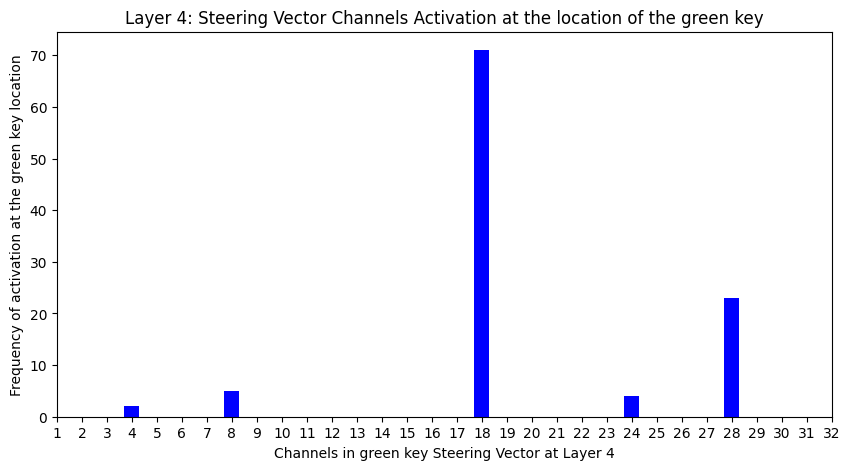

64 64
1
activation width 16.0
ratio 0.5625
range of activations 125 134
64 64
1
activation width 16.0
ratio 0.5625
range of activations 2 11
64 64
1
activation width 16.0
ratio 0.5625
range of activations 73 82
64 64
1
activation width 16.0
ratio 0.5625
range of activations 27 36
64 64
1
activation width 16.0
ratio 0.5625
range of activations 247 256
64 64
1
activation width 16.0
ratio 0.5625
range of activations 5 14
64 64
1
activation width 16.0
ratio 0.5625
range of activations 245 254
64 64
1
activation width 16.0
ratio 0.5625
range of activations 7 16
64 64
1
activation width 16.0
ratio 0.5625
range of activations 183 192
64 64
1
activation width 16.0
ratio 0.5625
range of activations 180 189
64 64
1
activation width 16.0
ratio 0.5625
range of activations 154 163
64 64
1
activation width 16.0
ratio 0.5625
range of activations 39 48
64 64
1
activation width 16.0
ratio 0.5625
range of activations 73 82
64 64
1
activation width 16.0
ratio 0.5625
range of activations 139 148
64 64
1
a

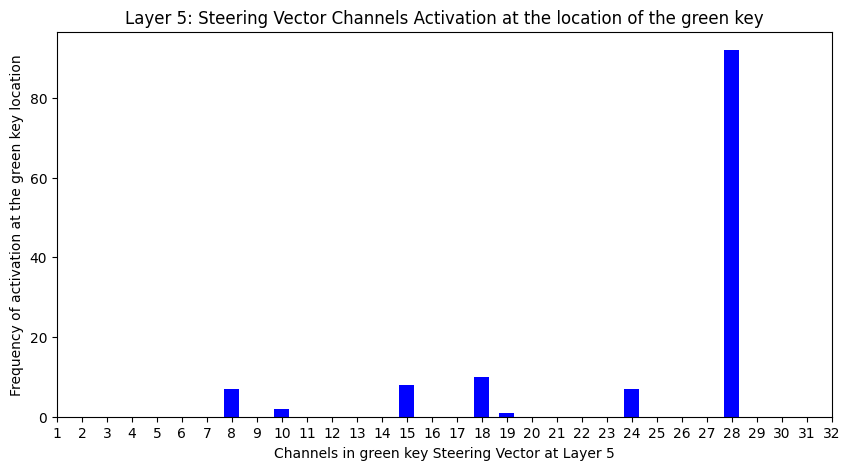

64 64
1
activation width 16.0
ratio 0.5625
range of activations 151 160
64 64
1
activation width 16.0
ratio 0.5625
range of activations 96 105
64 64
1
activation width 16.0
ratio 0.5625
range of activations 75 84
64 64
1
activation width 16.0
ratio 0.5625
range of activations 99 108
64 64
1
activation width 16.0
ratio 0.5625
range of activations 116 125
64 64
1
activation width 16.0
ratio 0.5625
range of activations 151 160
64 64
1
activation width 16.0
ratio 0.5625
range of activations 92 101
64 64
1
activation width 16.0
ratio 0.5625
range of activations 36 45
64 64
1
activation width 16.0
ratio 0.5625
range of activations 219 228
64 64
1
activation width 16.0
ratio 0.5625
range of activations 100 109
64 64
1
activation width 16.0
ratio 0.5625
range of activations 103 112
64 64
1
activation width 16.0
ratio 0.5625
range of activations 250 259
64 64
1
activation width 16.0
ratio 0.5625
range of activations 181 190
64 64
1
activation width 16.0
ratio 0.5625
range of activations 69 78
6

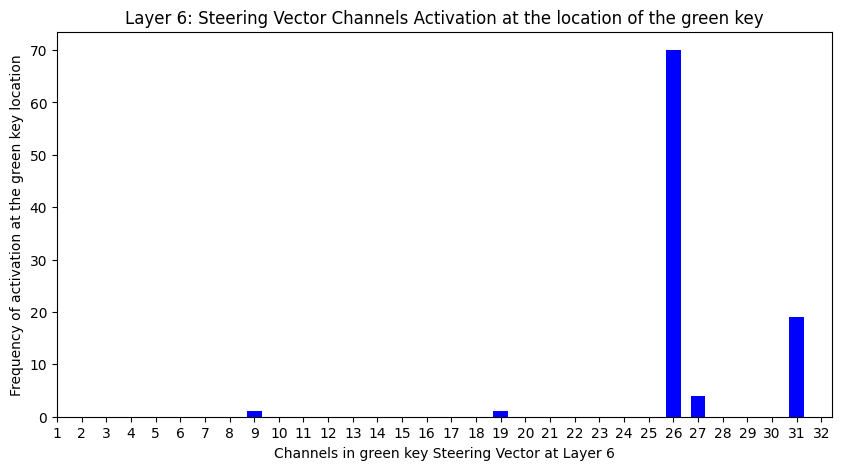

64 64
1
activation width 8.0
ratio 1.125
range of activations 43 48
64 64
1
activation width 8.0
ratio 1.125
range of activations 39 44
64 64
1
activation width 8.0
ratio 1.125
range of activations 25 30
64 64
1
activation width 8.0
ratio 1.125
range of activations 31 36
64 64
1
activation width 8.0
ratio 1.125
range of activations 60 65
64 64
1
activation width 8.0
ratio 1.125
range of activations 1 6
64 64
1
activation width 8.0
ratio 1.125
range of activations 43 48
64 64
1
activation width 8.0
ratio 1.125
range of activations 44 49
64 64
1
activation width 8.0
ratio 1.125
range of activations 59 64
64 64
1
activation width 8.0
ratio 1.125
range of activations 20 25
64 64
1
activation width 8.0
ratio 1.125
range of activations 19 24
64 64
1
activation width 8.0
ratio 1.125
range of activations 56 61
64 64
1
activation width 8.0
ratio 1.125
range of activations 43 48
64 64
1
activation width 8.0
ratio 1.125
range of activations -2 3
64 64
1
activation width 8.0
ratio 1.125
64 64
1
ac

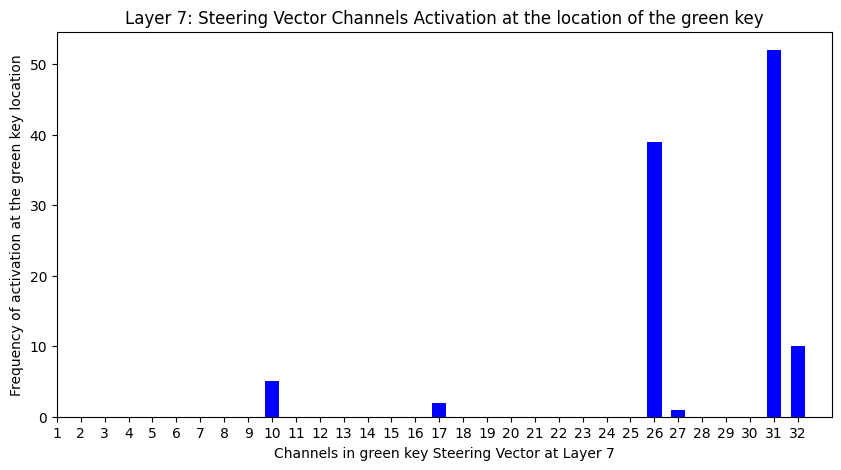

64 64
1
activation width 8.0
ratio 1.125
range of activations 61 66
64 64
1
activation width 8.0
ratio 1.125
range of activations 3 8
64 64
1
activation width 8.0
ratio 1.125
range of activations 55 60
64 64
1
activation width 8.0
ratio 1.125
range of activations 18 23
64 64
1
activation width 8.0
ratio 1.125
range of activations 24 29
64 64
1
activation width 8.0
ratio 1.125
range of activations 8 13
64 64
1
activation width 8.0
ratio 1.125
range of activations 53 58
64 64
1
activation width 8.0
ratio 1.125
range of activations 26 31
64 64
1
activation width 8.0
ratio 1.125
range of activations 42 47
64 64
1
activation width 8.0
ratio 1.125
range of activations 32 37
64 64
1
activation width 8.0
ratio 1.125
range of activations 38 43
64 64
1
activation width 8.0
ratio 1.125
range of activations 49 54
64 64
1
activation width 8.0
ratio 1.125
range of activations 54 59
64 64
1
activation width 8.0
ratio 1.125
range of activations 27 32
64 64
1
activation width 8.0
ratio 1.125
range of a

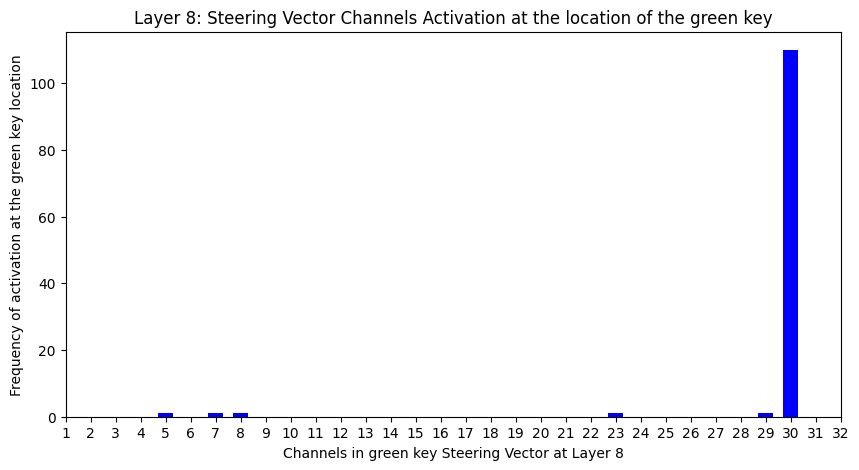

64 64
1
activation width 4.0
ratio 2.25
range of activations 3 6
64 64
1
activation width 4.0
ratio 2.25
range of activations 9 12
64 64
1
activation width 4.0
ratio 2.25
range of activations 4 7
64 64
1
activation width 4.0
ratio 2.25
range of activations 2 5
64 64
1
activation width 4.0
ratio 2.25
range of activations 7 10
64 64
1
activation width 4.0
ratio 2.25
range of activations 1 4
64 64
1
activation width 4.0
ratio 2.25
range of activations 8 11
64 64
1
activation width 4.0
ratio 2.25
range of activations 12 15
64 64
1
activation width 4.0
ratio 2.25
range of activations 2 5
64 64
1
activation width 4.0
ratio 2.25
range of activations 14 17
64 64
1
activation width 4.0
ratio 2.25
range of activations 0 3
64 64
1
activation width 4.0
ratio 2.25
range of activations 7 10
64 64
1
activation width 4.0
ratio 2.25
range of activations 11 14
64 64
1
activation width 4.0
ratio 2.25
range of activations 5 8
64 64
1
activation width 4.0
ratio 2.25
range of activations 3 6
64 64
1
activat

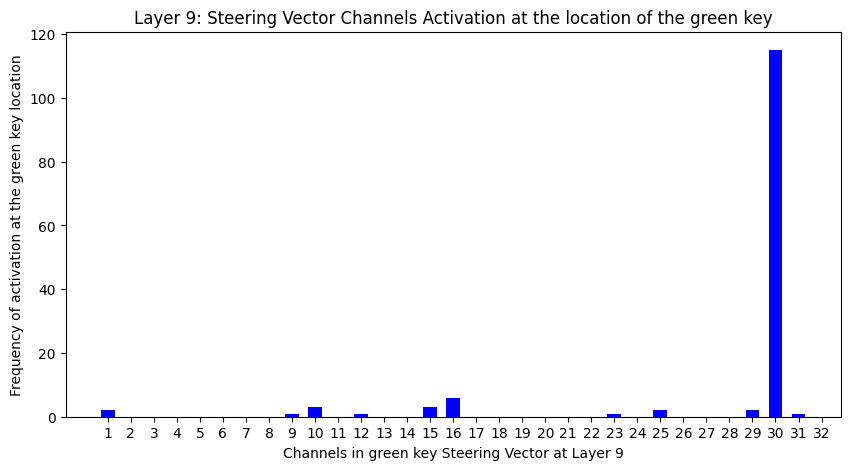

In [8]:
for layer_number in range(8,9):
    dataset = get_venvs_objective_steering("key", "green",200)
    from src.utils.steering_experiments import steering_vector
    model_path ="model_interpretable.pt"
    entity_name = "key"
    entity_color = "green"
    matrix_indices = {}
    for i in range(len(dataset)):
        filepath =f"../gifs/dataset{i}"
        venv = dataset[i]
        stv, original_position = steering_vector(venv= venv,model_path= model_path,layer_number = layer_number,entity_name=entity_name,entity_color=entity_color, filepath = filepath, save_gif = "False")
        sv= convert_to_list(stv)
        matrix_index, _, _ =find_largest_entry_all_layers(sv, original_position)
        if matrix_index != -1:
            if matrix_index not in matrix_indices:
                matrix_indices[matrix_index] = 1
            else:
                matrix_indices[matrix_index] += 1

    print_histogram(matrix_indices, layer_number, entity_color + " " + entity_name)


64 64
0
64 64
0
64 64
0
64 64
0
64 64
0
64 64
0
64 64
0
64 64
0
64 64
0
64 64
0
64 64
0
64 64
0
64 64
0
64 64
0
64 64
0
64 64
0
64 64
0
64 64
0
64 64
0
64 64
0
64 64
0
64 64
0
64 64
0
64 64
0
64 64
0
64 64
0
64 64
0
64 64
0
64 64
0
64 64
0
64 64
0
64 64
0
64 64
0
64 64
0
64 64
0
64 64
0
64 64
0
64 64
0
64 64
0
64 64
0
64 64
0
64 64
0
64 64
0
64 64
0
64 64
0
64 64
0
64 64
0
64 64
0
64 64
0
64 64
0
64 64
0
64 64
0
64 64
0
64 64
0
64 64
0
64 64
0
64 64
0
64 64
0
64 64
0
64 64
0
64 64
0
64 64
0
64 64
0
64 64
0
64 64
0
64 64
0
64 64
0
64 64
0
64 64
0
64 64
0
64 64
0
64 64
0
64 64
0
64 64
0
64 64
0
64 64
0
64 64
0
64 64
0
64 64
0
64 64
0
64 64
0
64 64
0
64 64
0
64 64
0
64 64
0
64 64
0
64 64
0
64 64
0
64 64
0
64 64
0
64 64
0
64 64
0
64 64
0
64 64
0
64 64
0
64 64
0
64 64
0
64 64
0
64 64
0
64 64
0
64 64
0
64 64
0
64 64
0
64 64
0
64 64
0
64 64
0
64 64
0
64 64
0
64 64
0
64 64
0
64 64
0
64 64
0
64 64
0
64 64
0
64 64
0
64 64
0
64 64
0
64 64
0
64 64
0
64 64
0
64 64
0
64 64
0
64 64
0
64 64
0
64 64
0


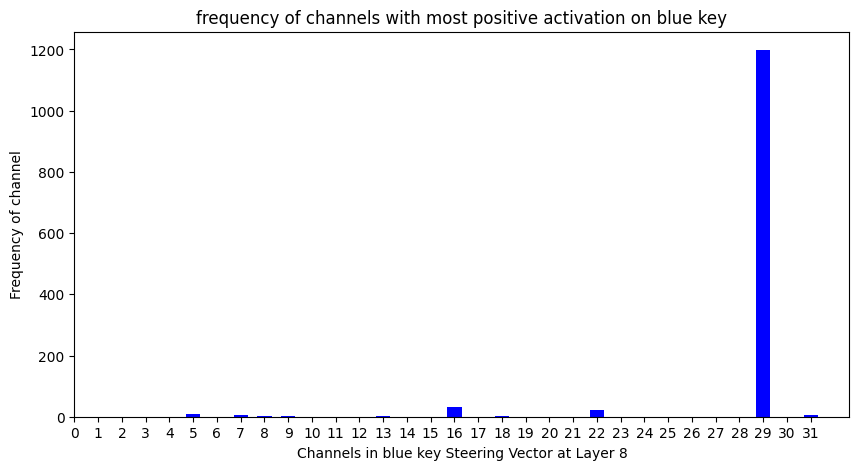

In [50]:
for layer_number in range(8,9):
    dataset = get_venvs_objective_steering("key", "blue",2000)
    from src.utils.steering_experiments import steering_vector
    model_path ="model_interpretable.pt"
    entity_name = "key"
    entity_color = "blue"
    matrix_indices = {}
    for i in range(len(dataset)):
        filepath =f"../gifs/dataset{i}"
        venv = dataset[i]
        stv, original_position, blue_key_position = steering_vector(venv= venv,model_path= model_path,layer_number = layer_number,entity_name=entity_name,entity_color=entity_color, filepath = filepath, save_gif = "False")
        sv= convert_to_list(stv)
        matrix_index, _, _ = find_largest_entry_all_layers(sv, original_position)            
        if matrix_index != -1:
            if matrix_index not in matrix_indices:
                matrix_indices[matrix_index] = 1

            else:
                matrix_indices[matrix_index] += 1


    print_histogram("frequency of channels with most positive activation on blue key",matrix_indices, layer_number, entity_color + " " + entity_name)

64 64
1


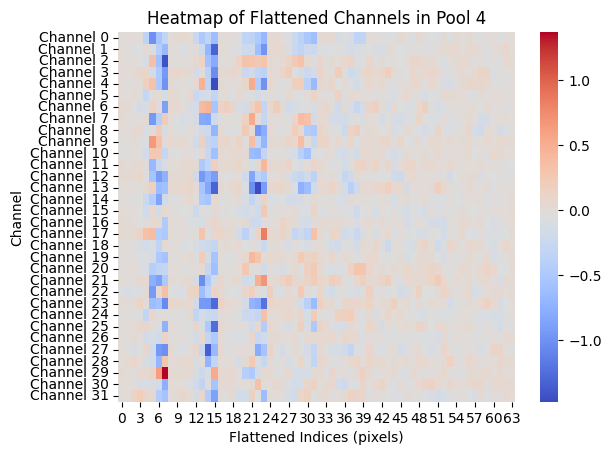

64 64
1


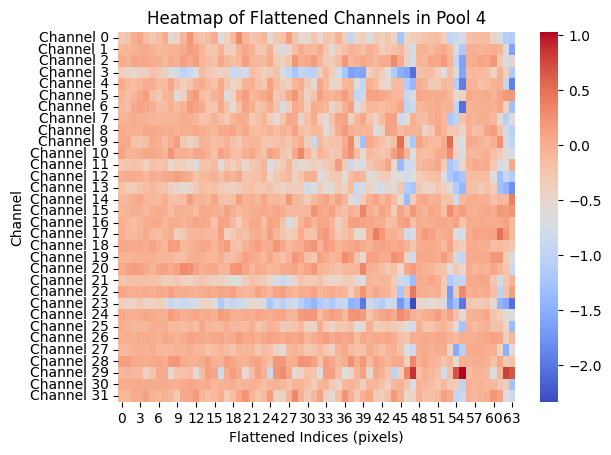

64 64
1


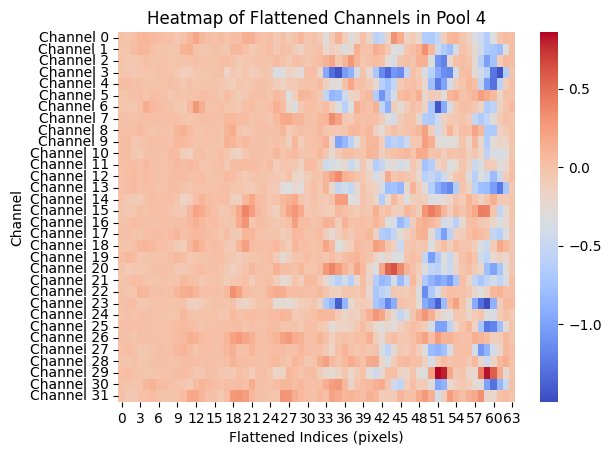

64 64
1


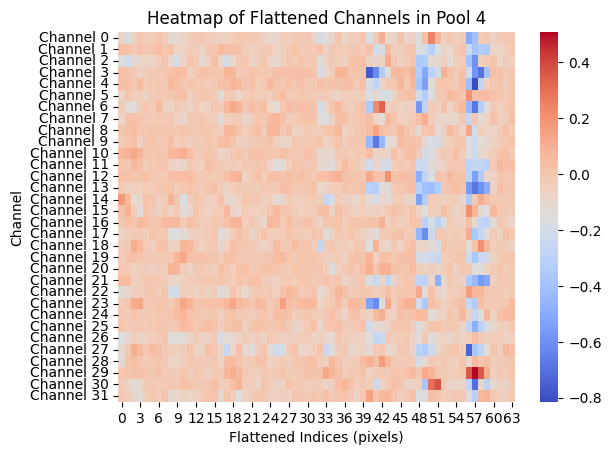

64 64
1


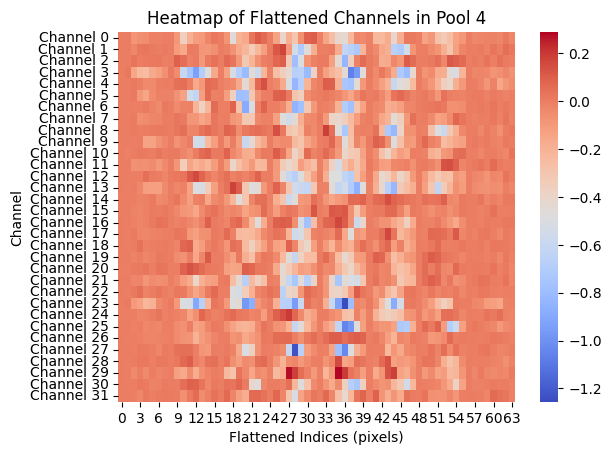

64 64
1


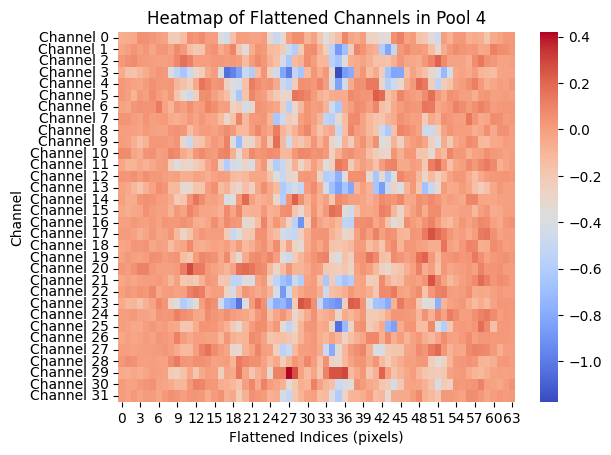

64 64
1


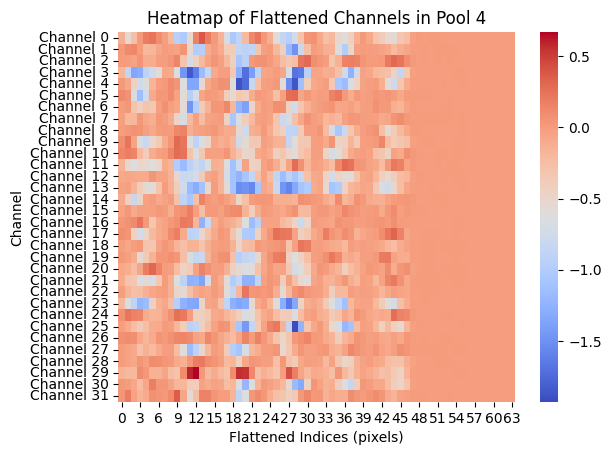

64 64
1


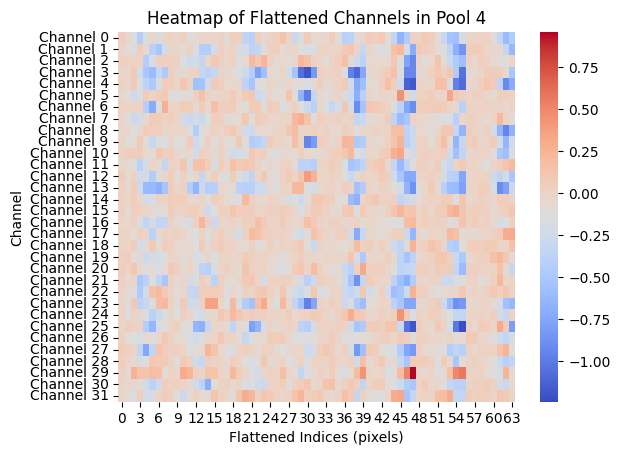

64 64
1


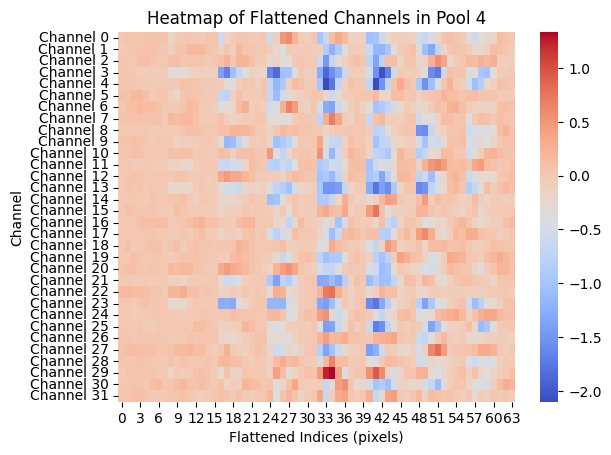

64 64
1


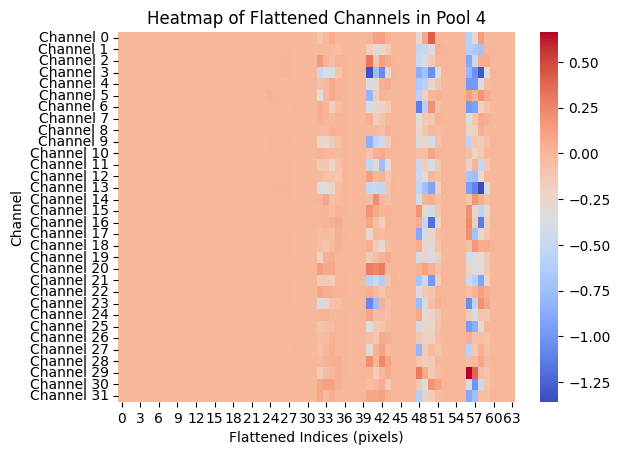

64 64
1


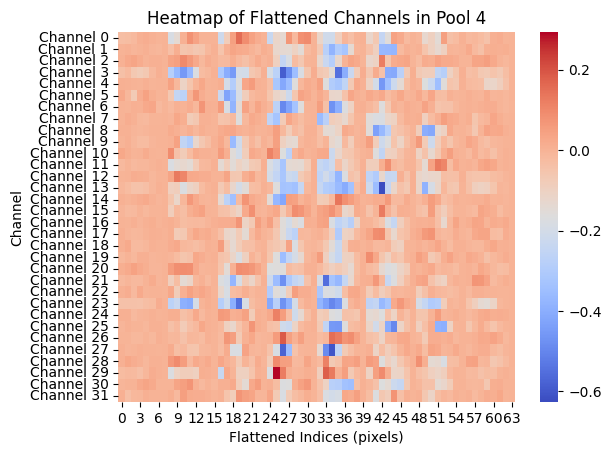

64 64
1


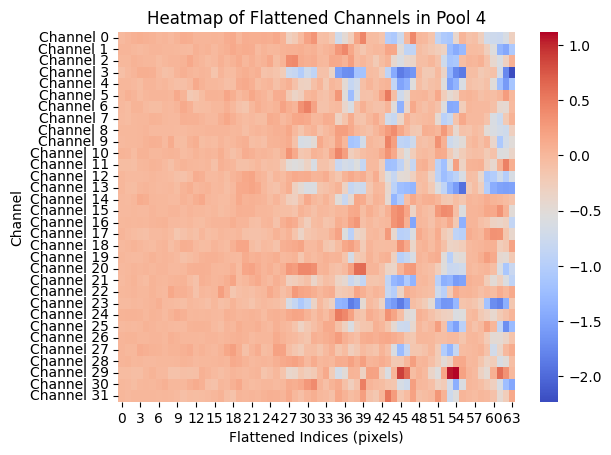

64 64
1


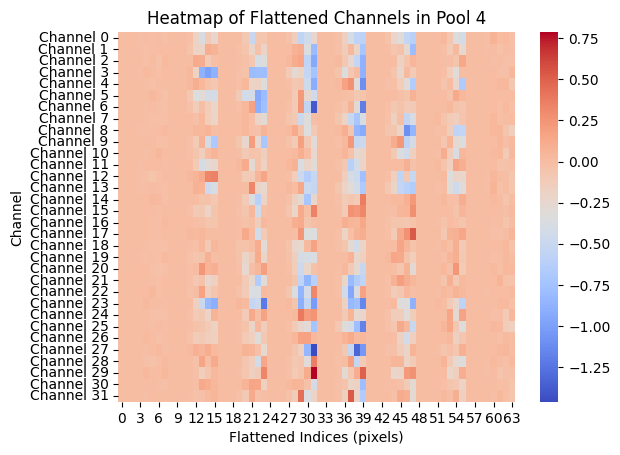

64 64
1


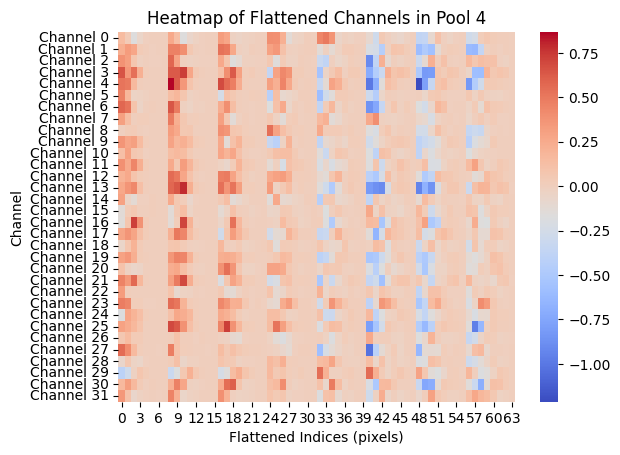

64 64
1


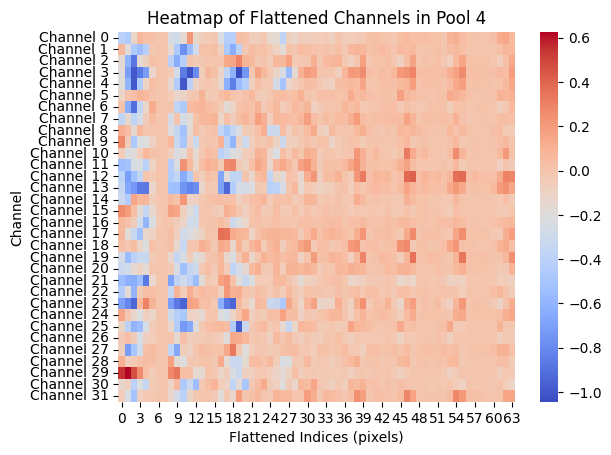

64 64
1


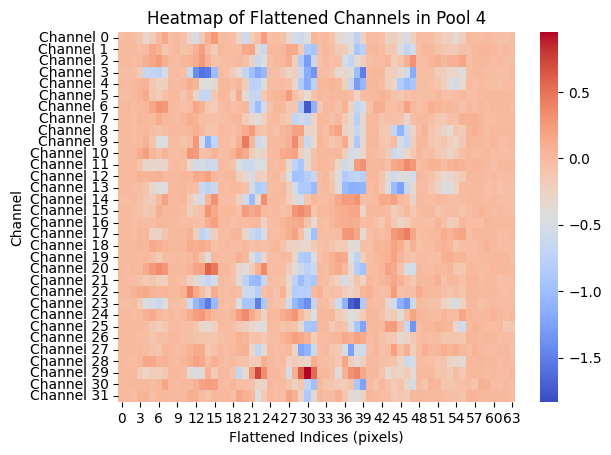

64 64
1


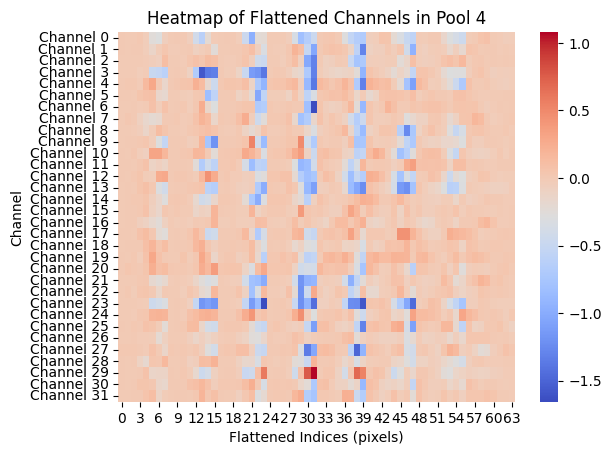

64 64
1


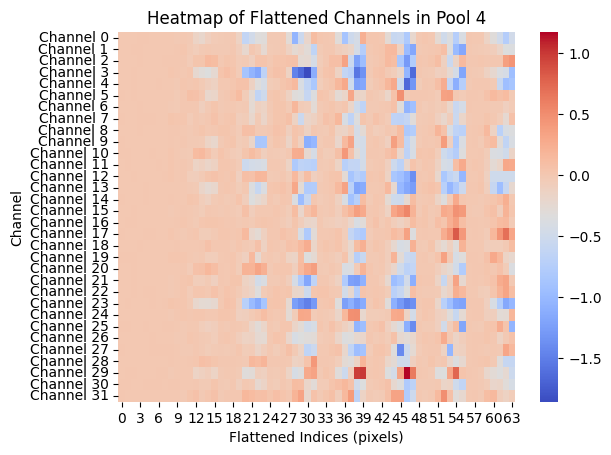

64 64
1


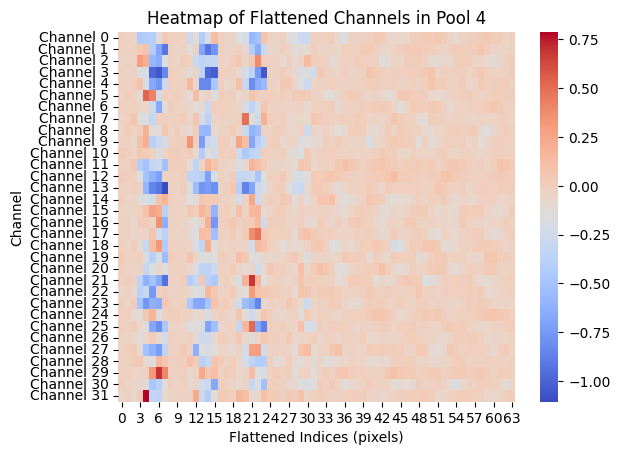

64 64
1


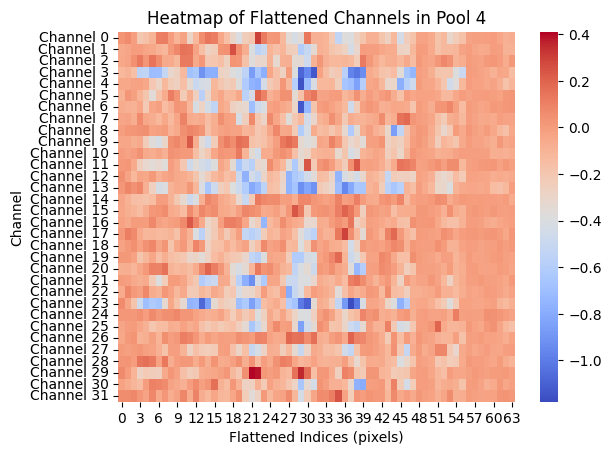

64 64
1


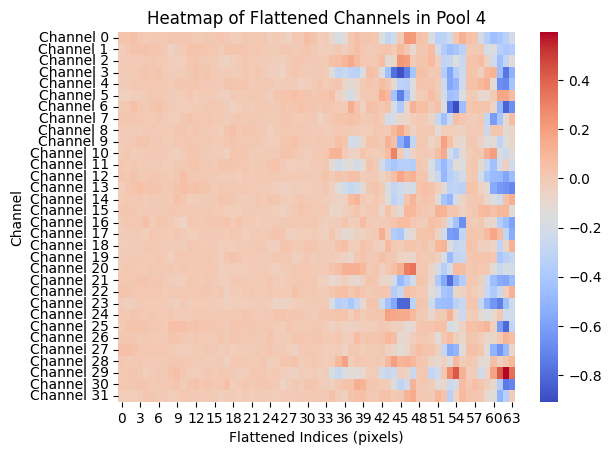

64 64
1


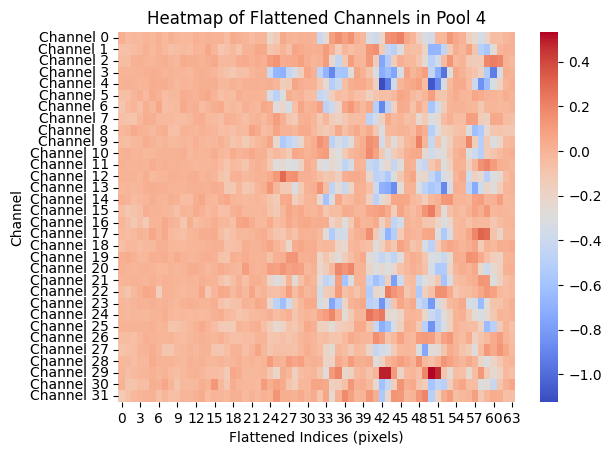

64 64
1


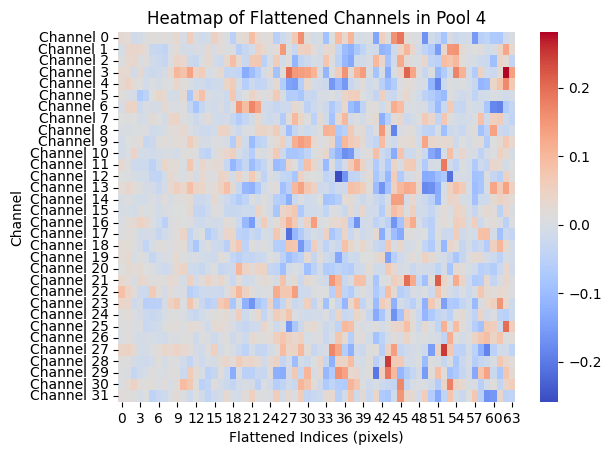

64 64
1


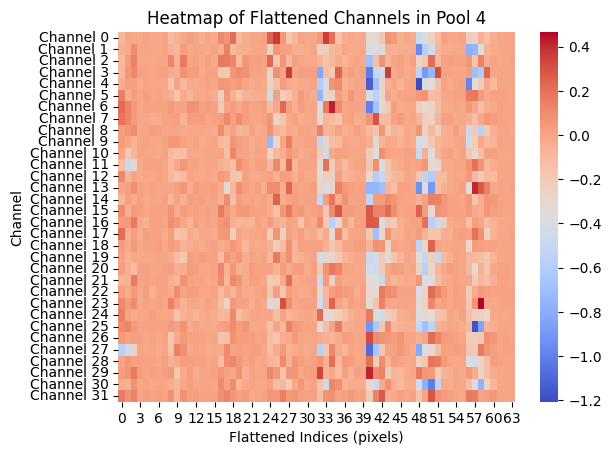

64 64
1


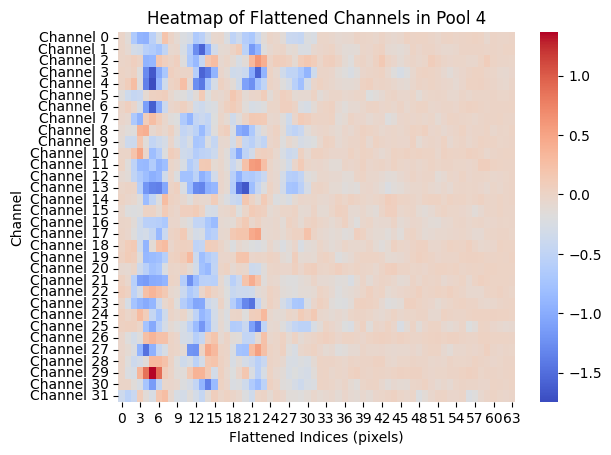

64 64
1


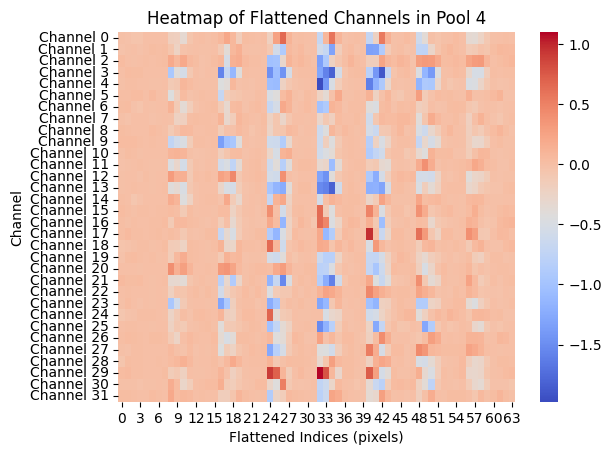

64 64
1


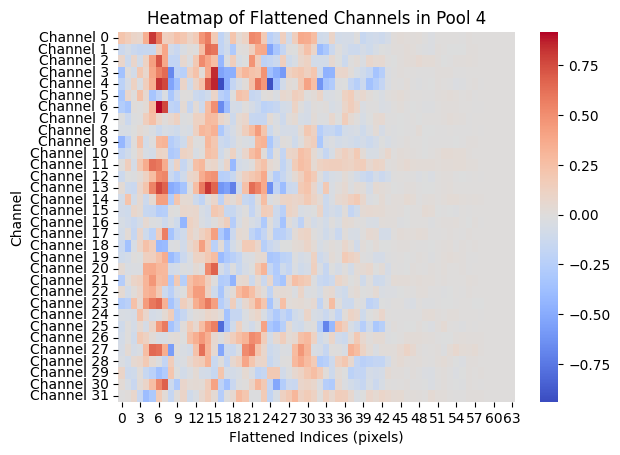

64 64
1


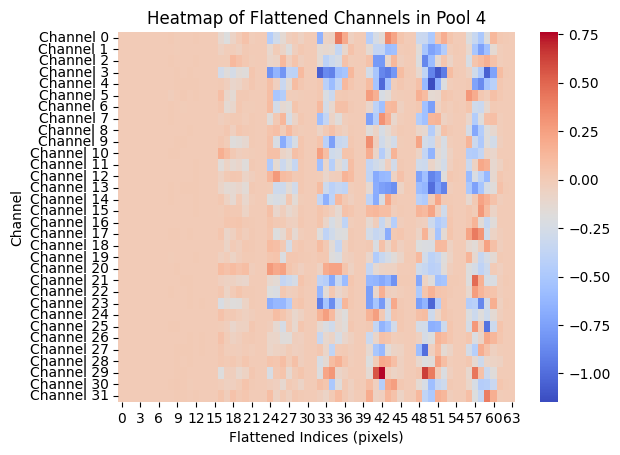

64 64
1


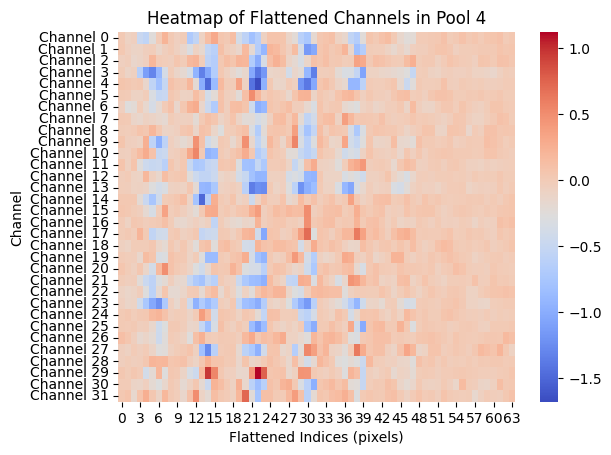

64 64
1


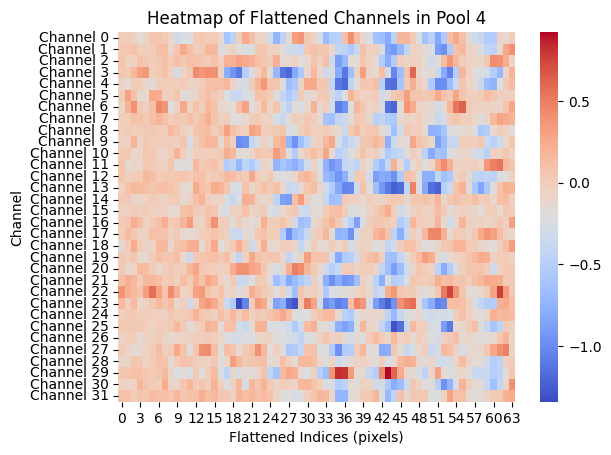

64 64
1


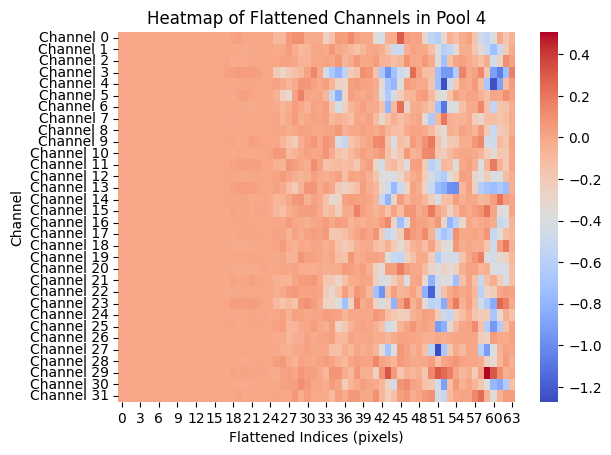

64 64
1


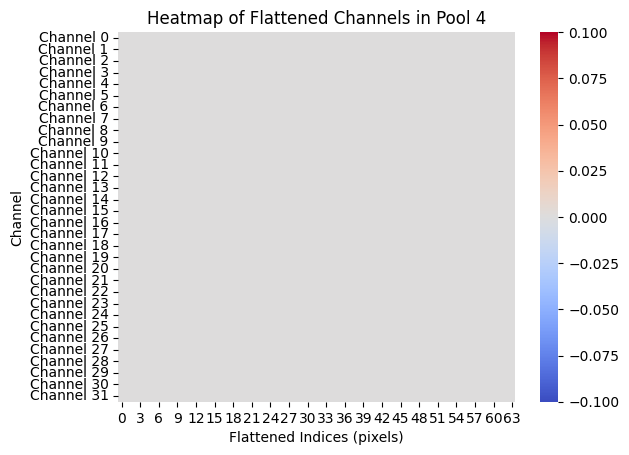

64 64
1


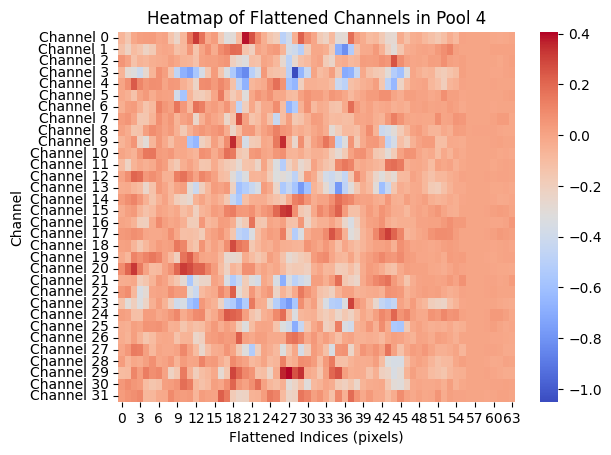

64 64
1


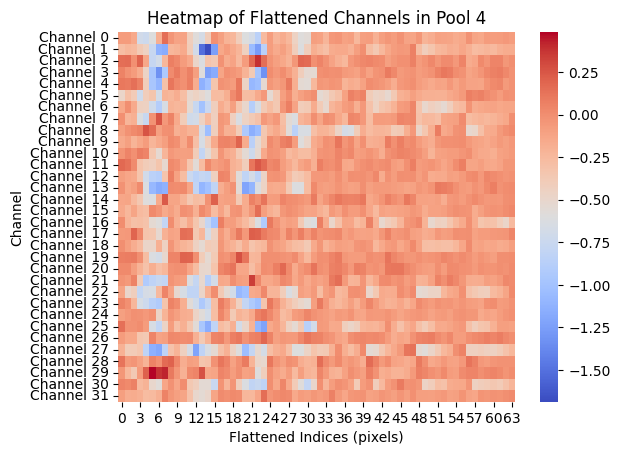

64 64
1


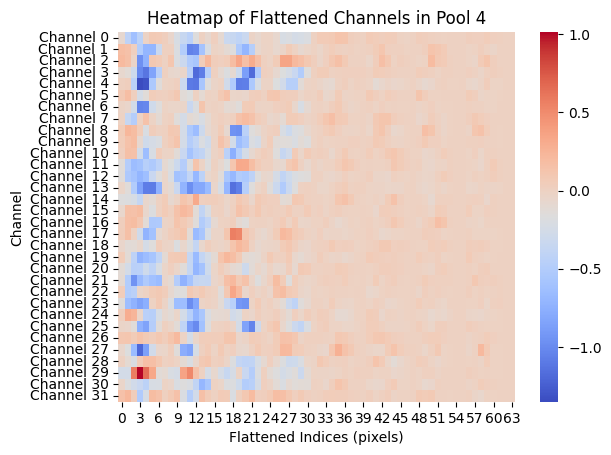

64 64
1


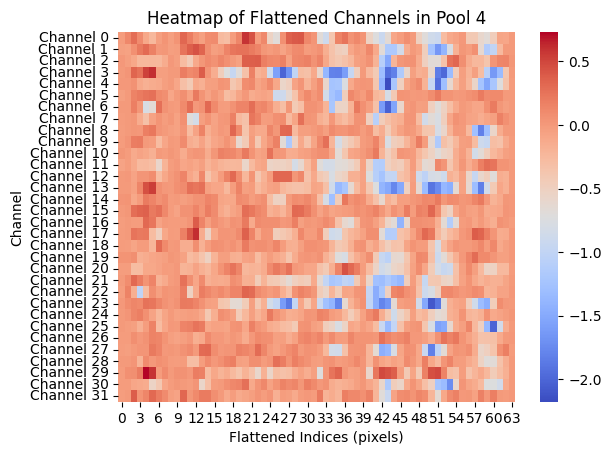

64 64
1


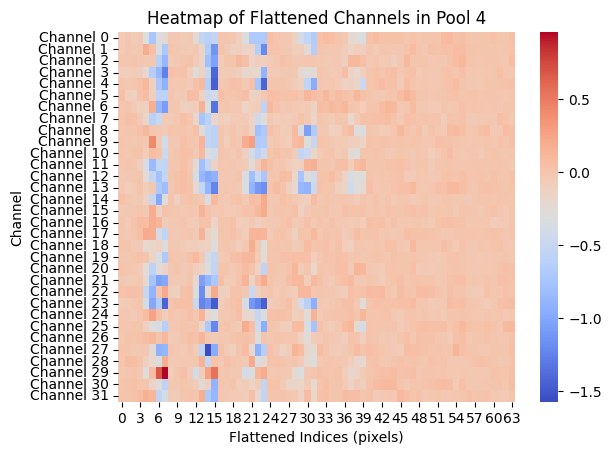

64 64
1


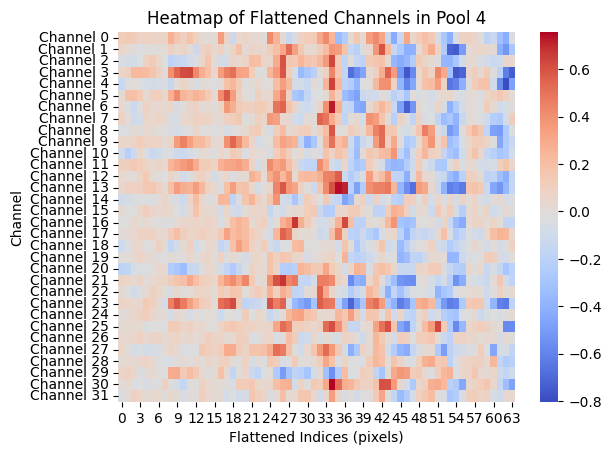

64 64
1


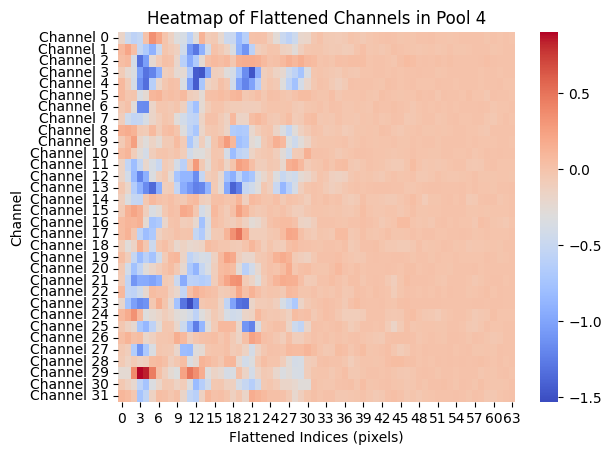

64 64
1


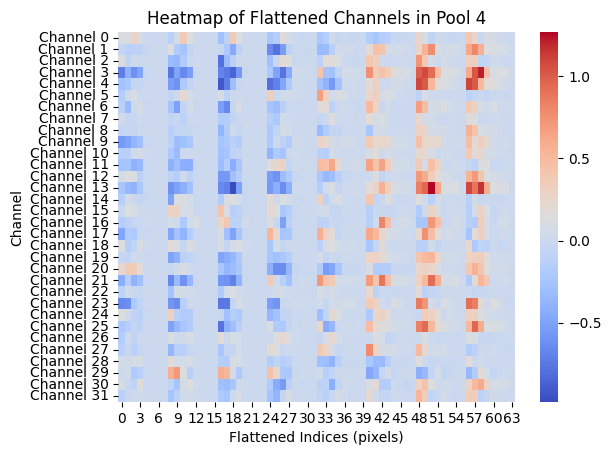

64 64
1


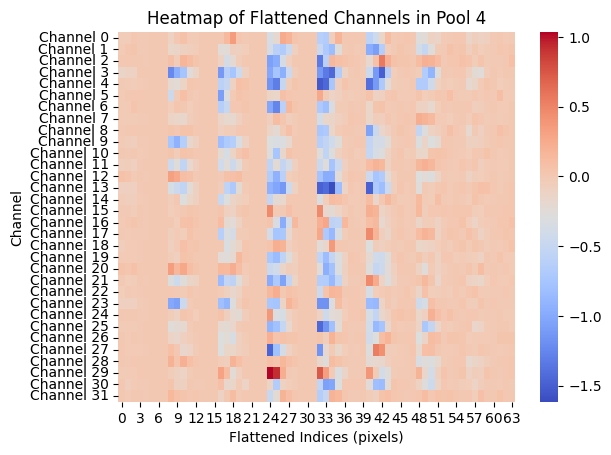

64 64
1


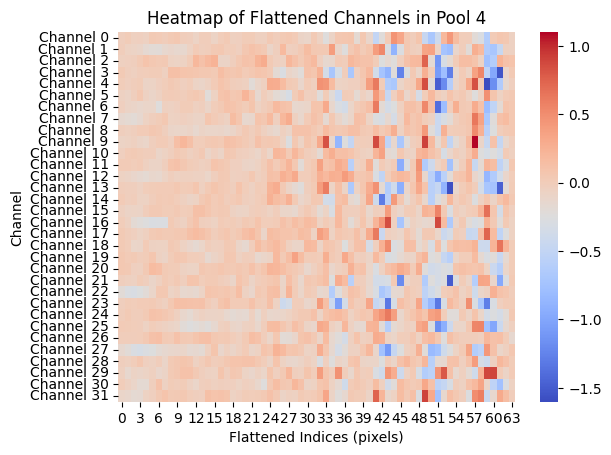

64 64
1


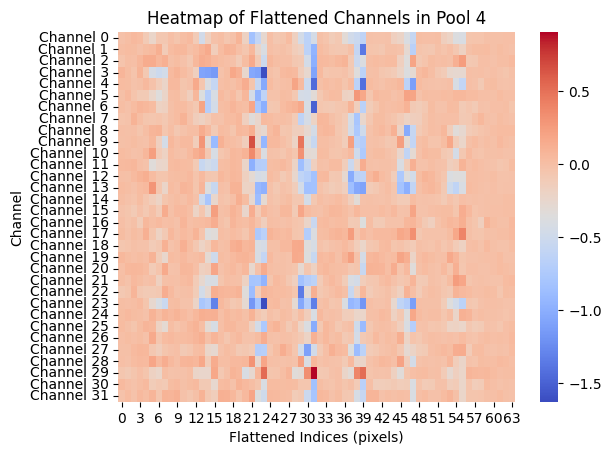

64 64
1


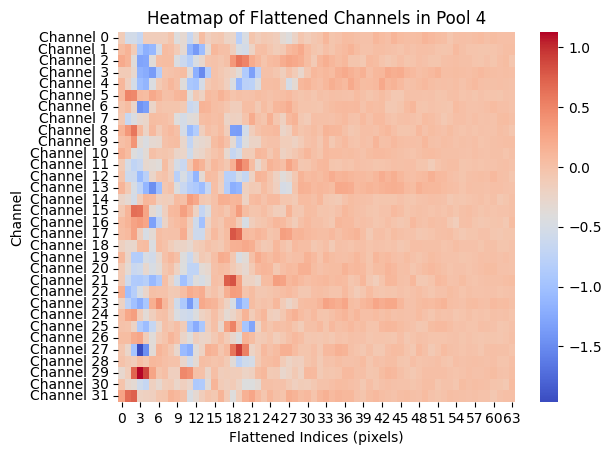

64 64
1


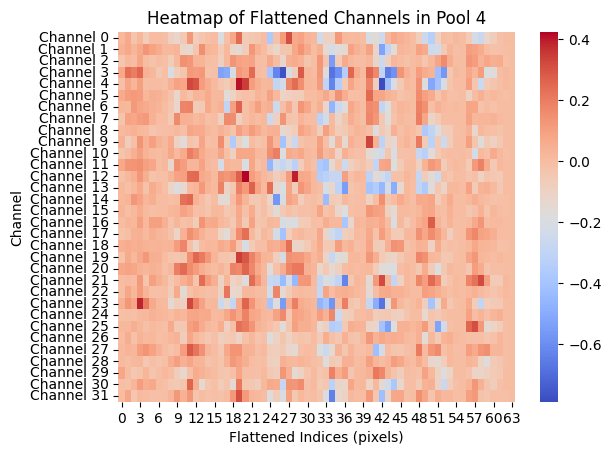

64 64
1


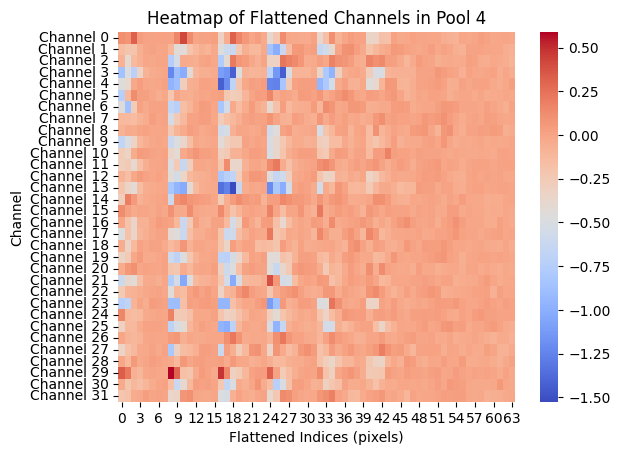

64 64
1


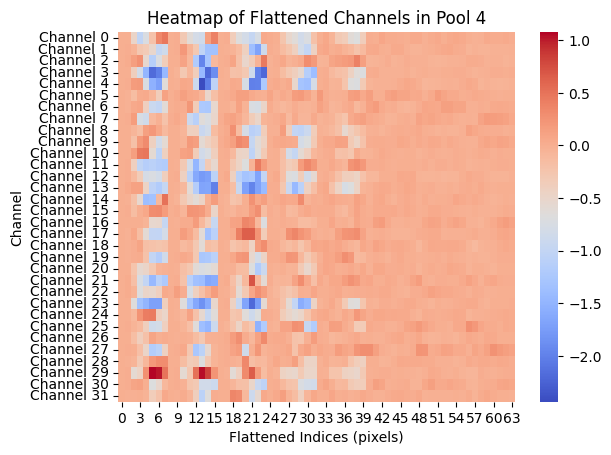

64 64
1


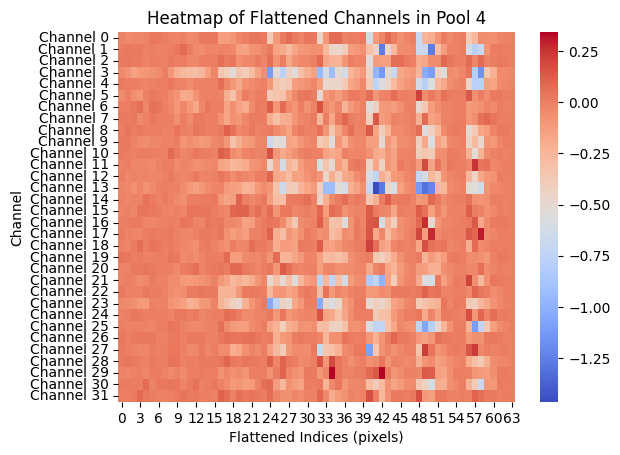

64 64
1


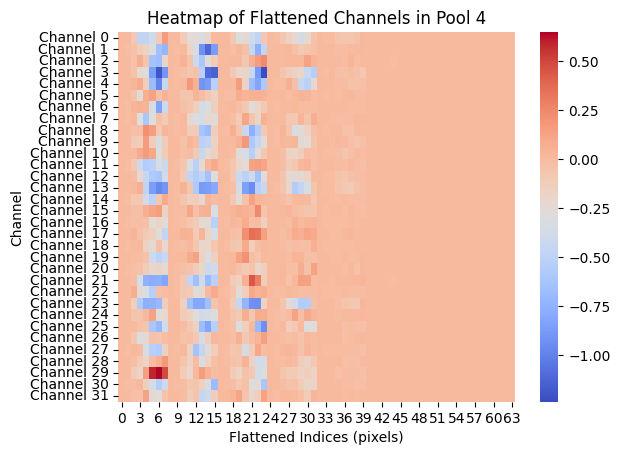

64 64
1


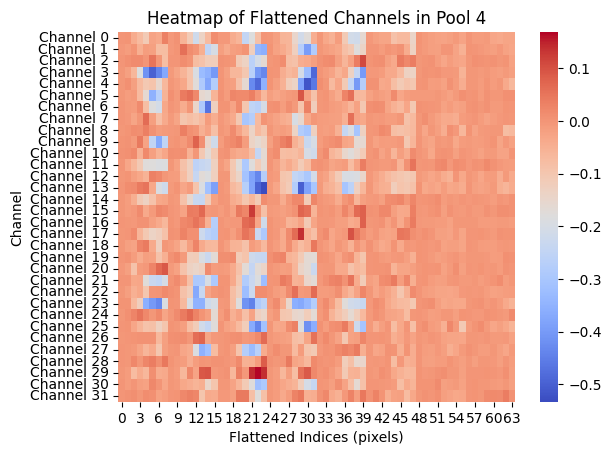

64 64
1


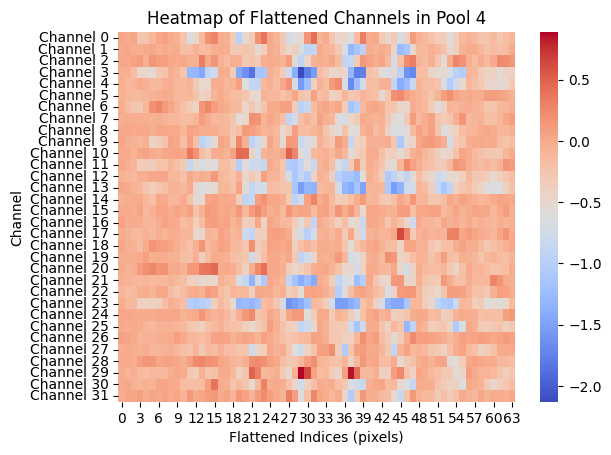

64 64
1


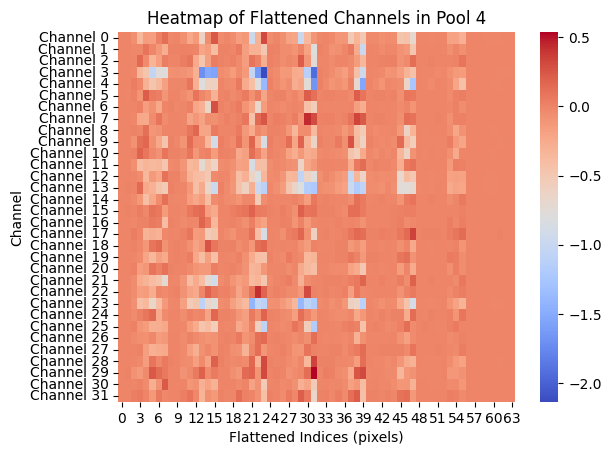

64 64
1


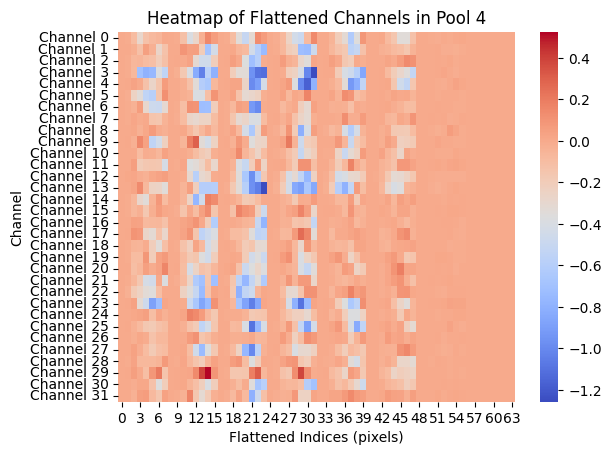

64 64
1


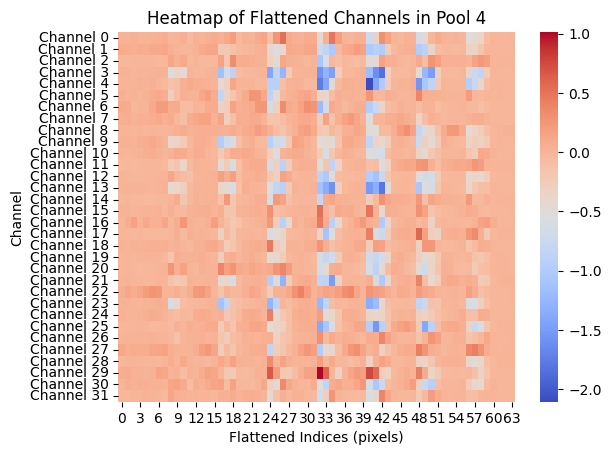

64 64
1


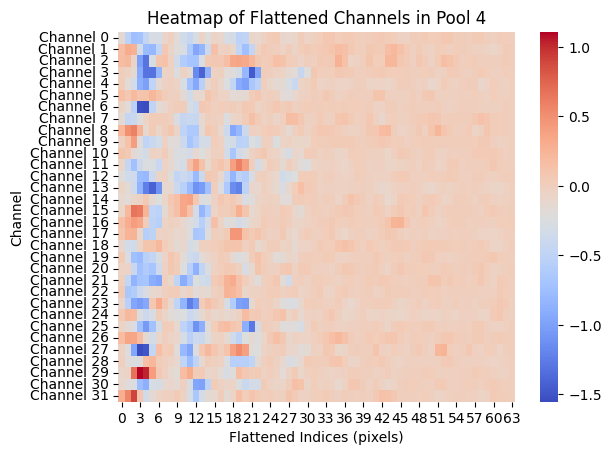

64 64
1


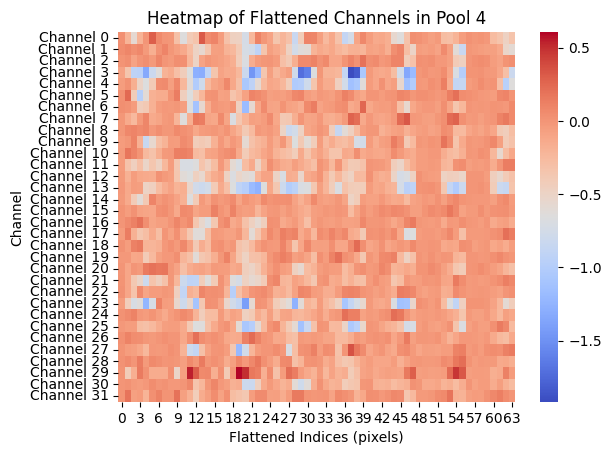

64 64
1


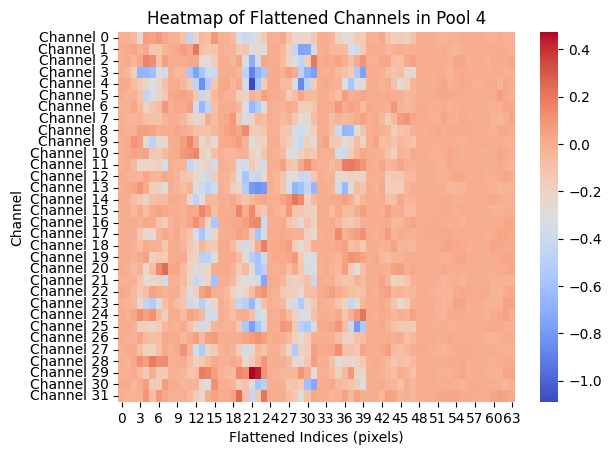

64 64
1


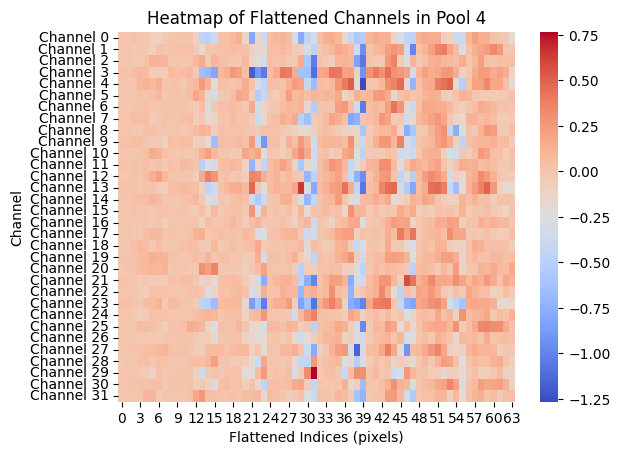

64 64
1


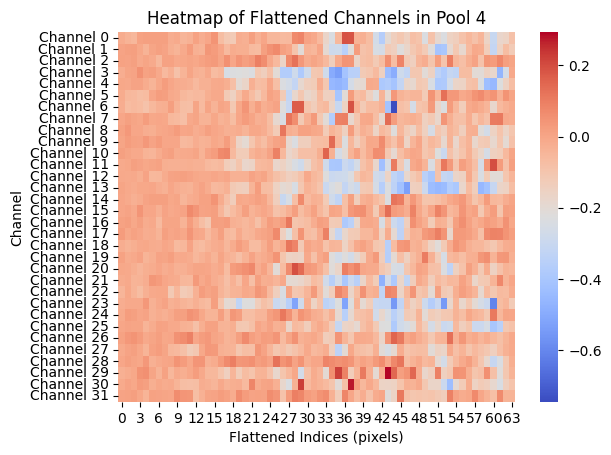

64 64
1


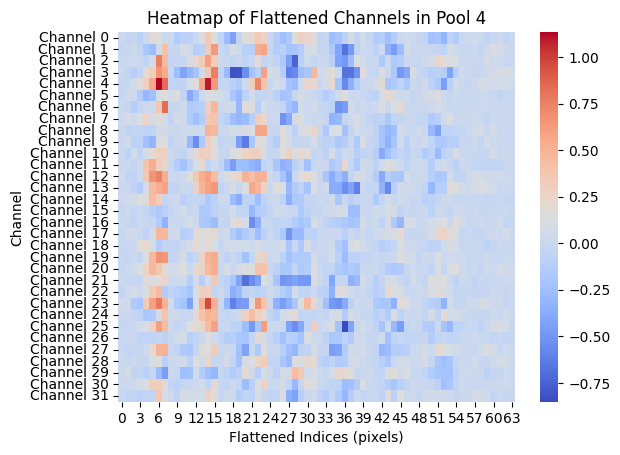

64 64
1


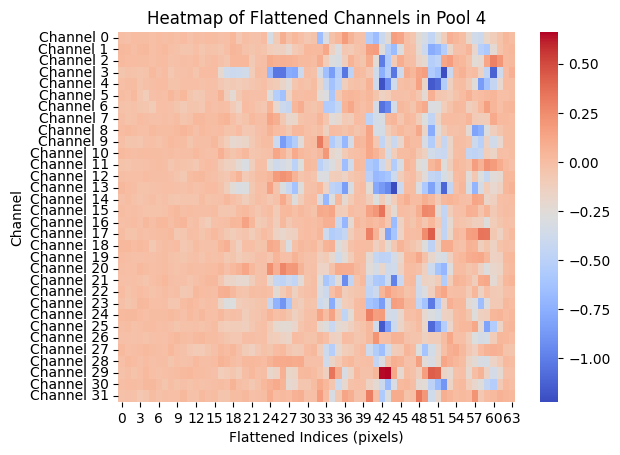

64 64
1


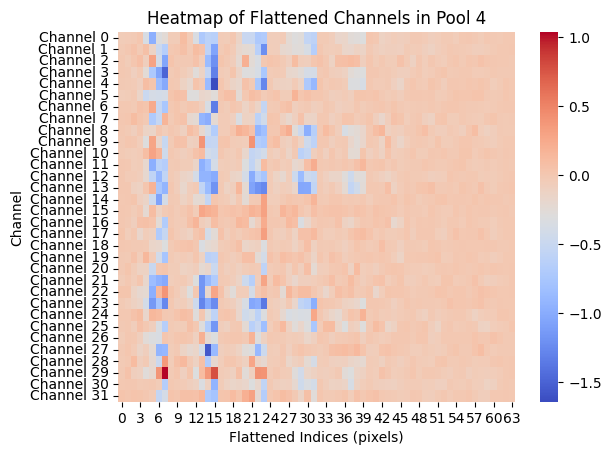

64 64
1


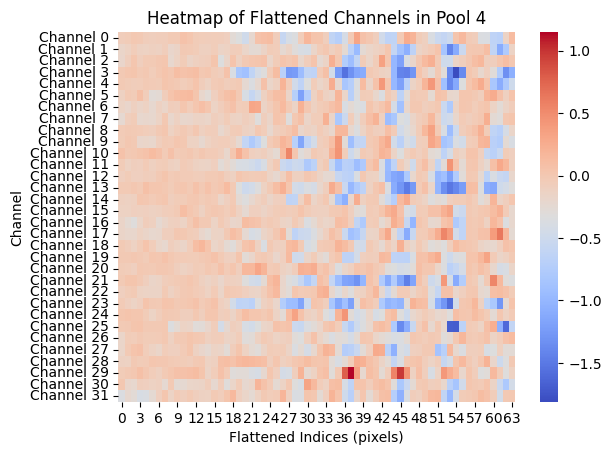

64 64
1


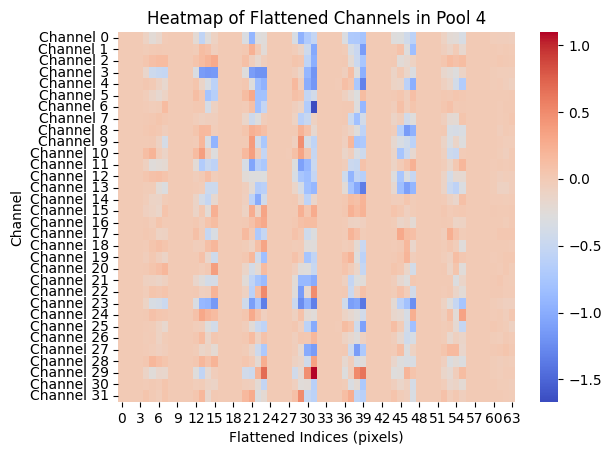

64 64
1


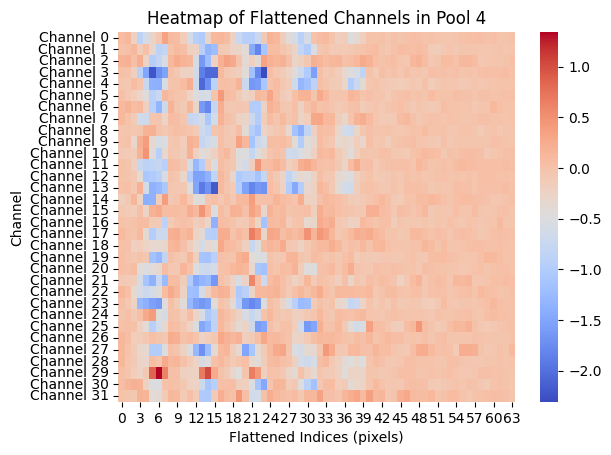

64 64
1


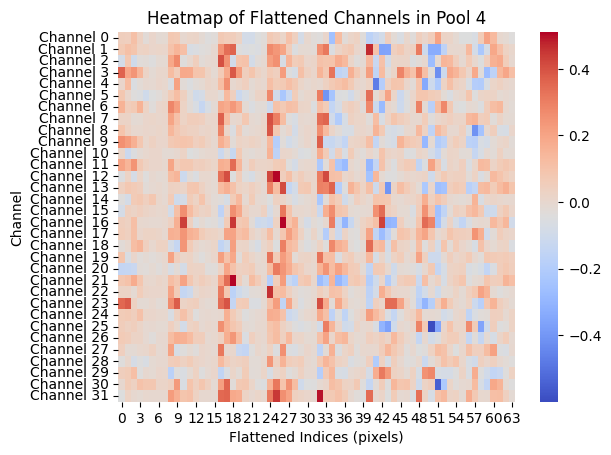

64 64
1


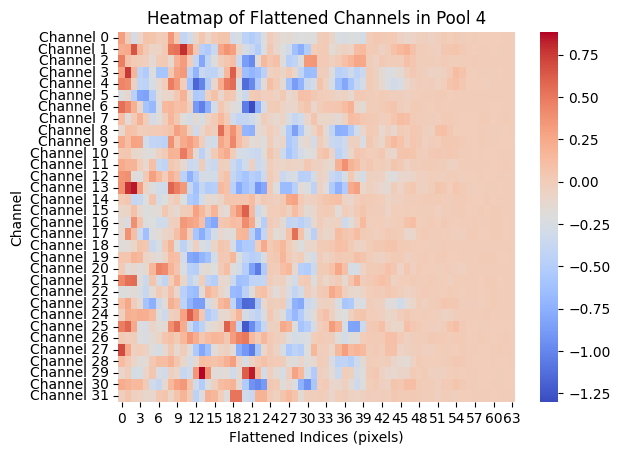

64 64
1


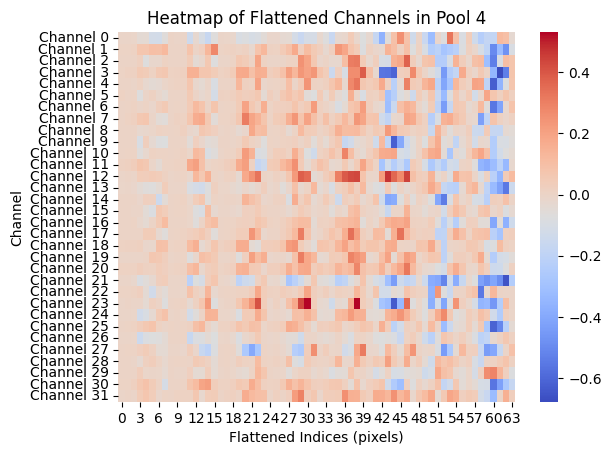

64 64
1


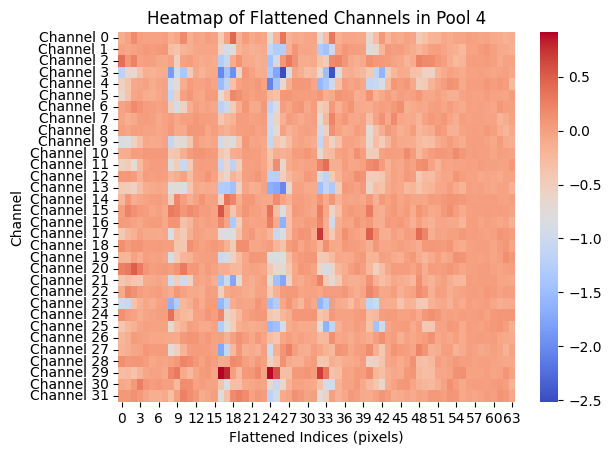

64 64
1


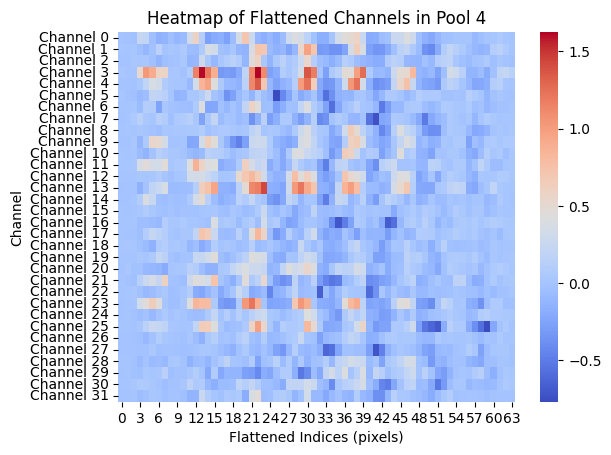

64 64
1


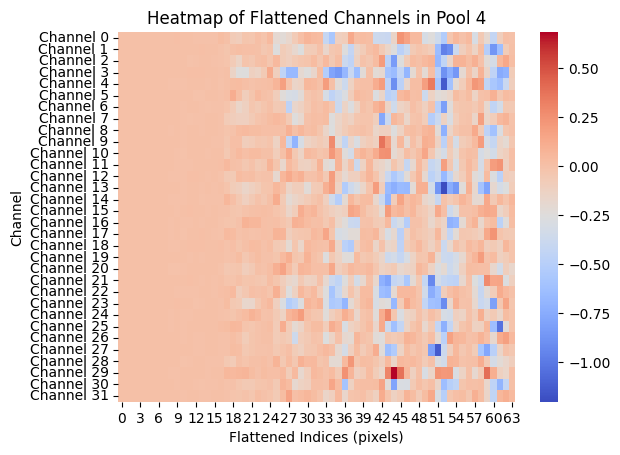

64 64
1


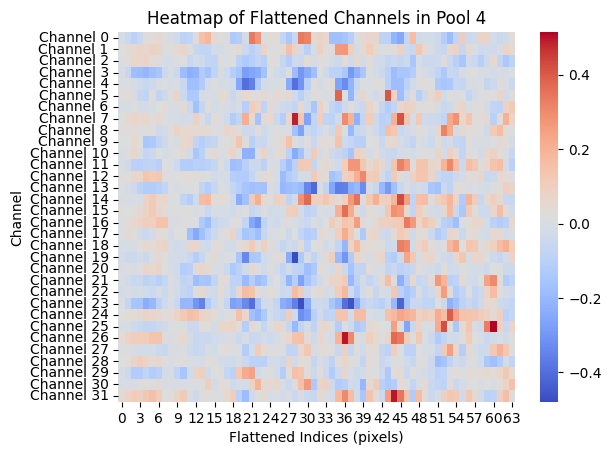

64 64
1


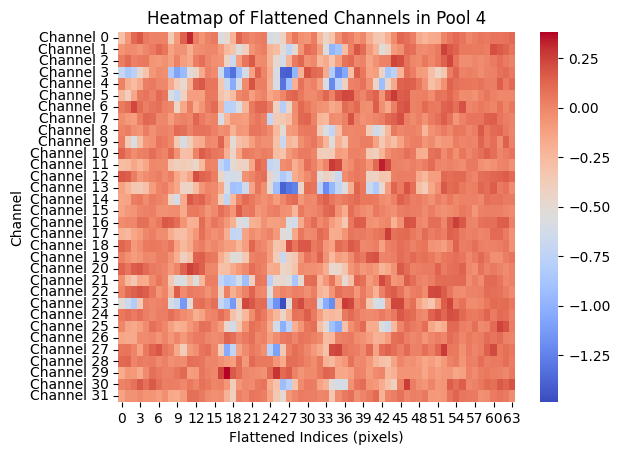

64 64
1


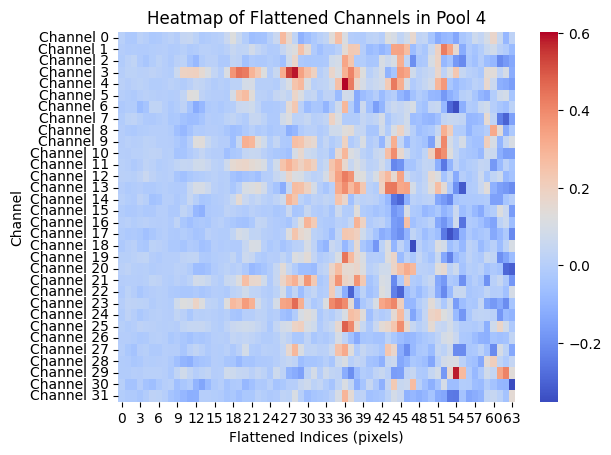

64 64
1


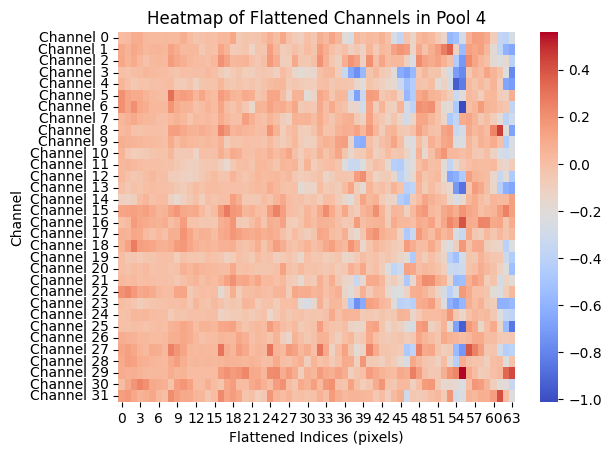

64 64
1


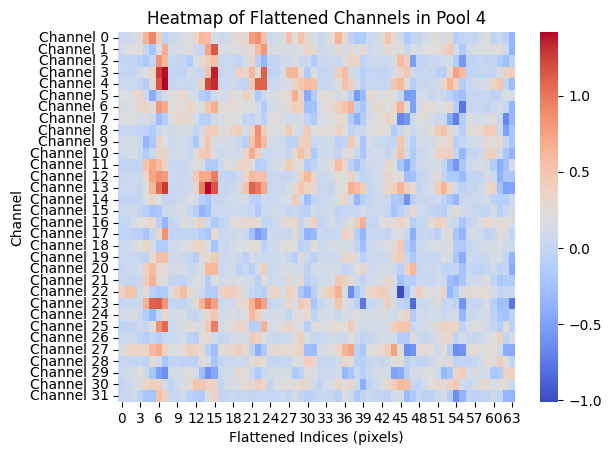

64 64
1


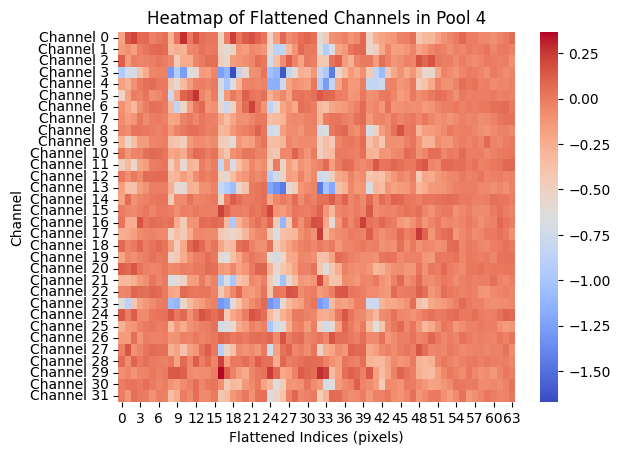

64 64
1


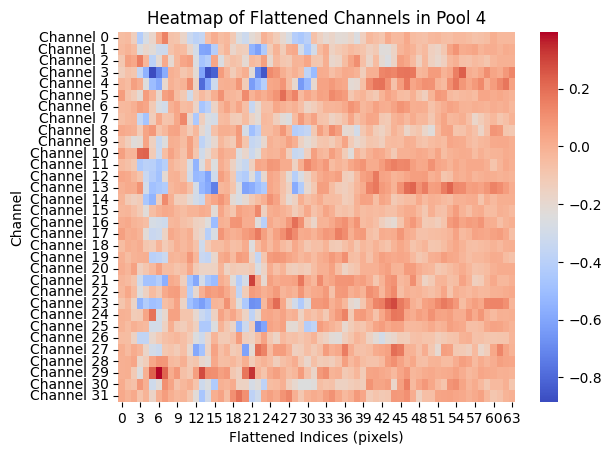

64 64
1


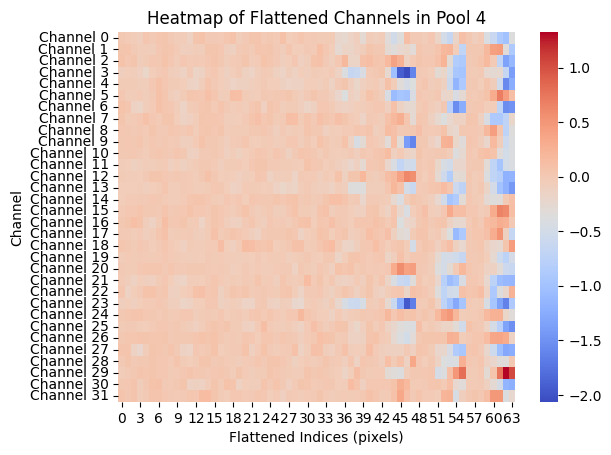

64 64
1


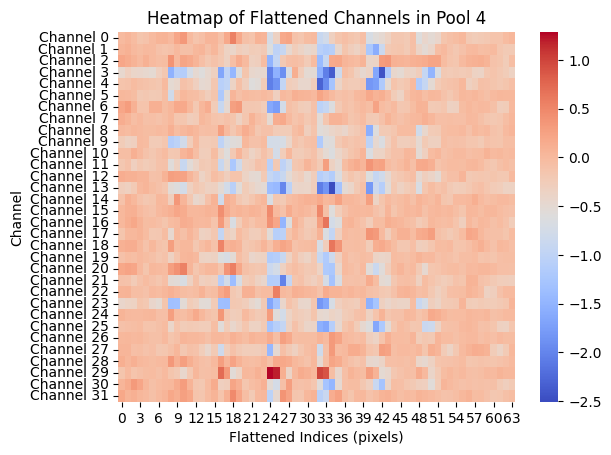

64 64
1


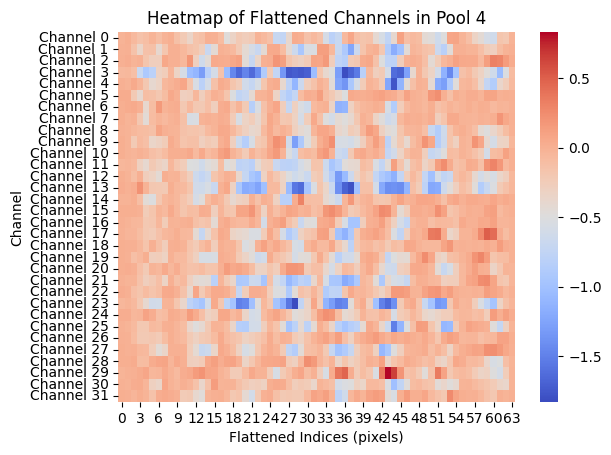

64 64
1


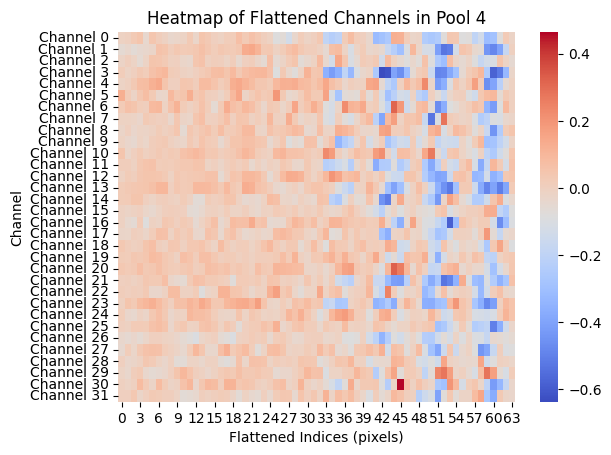

64 64
1


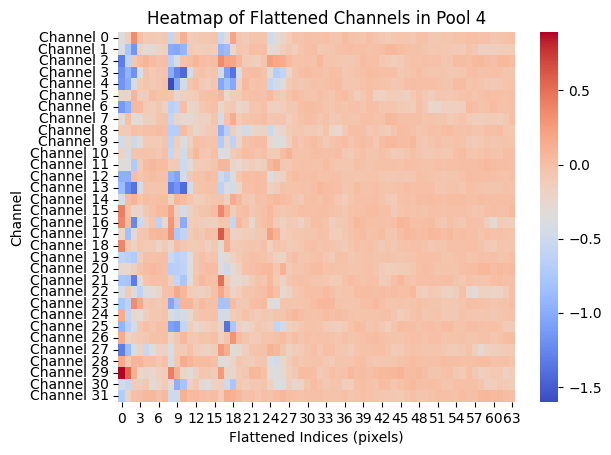

64 64
1


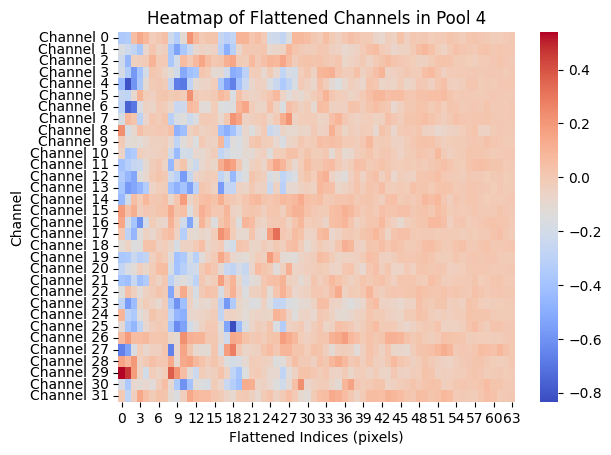

64 64
1


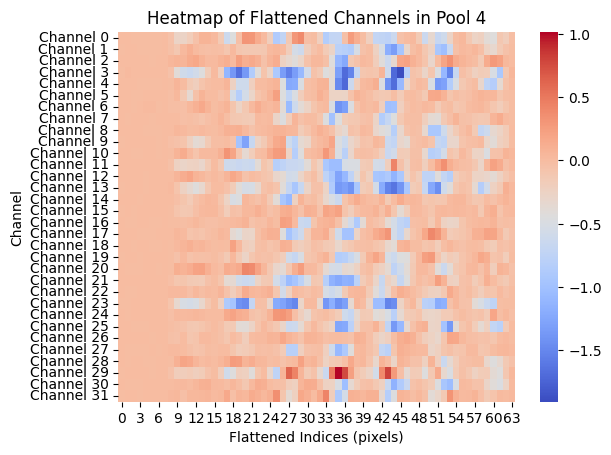

64 64
1


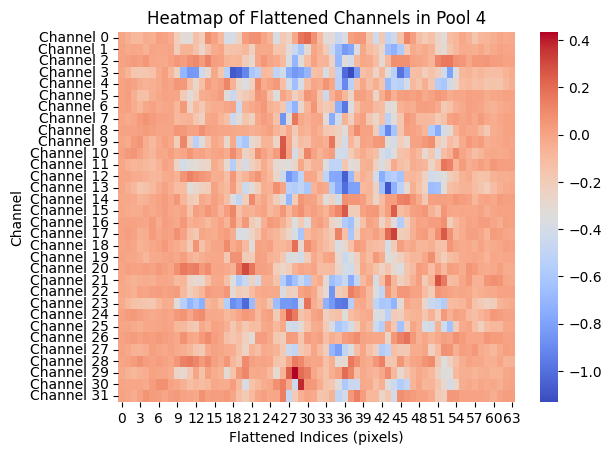

64 64
1


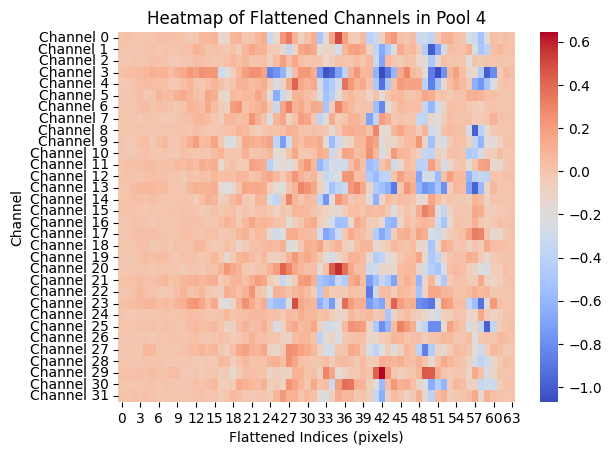

64 64
1


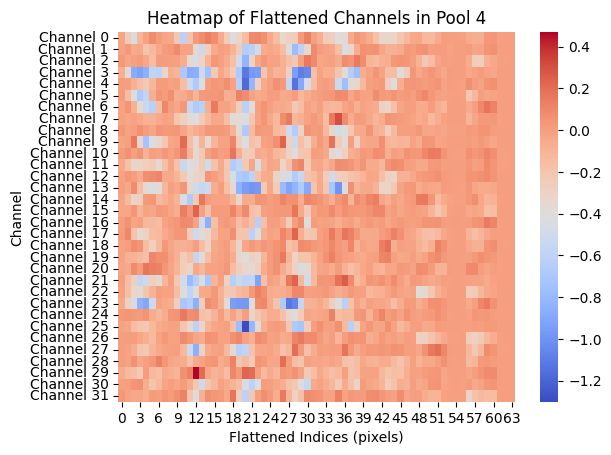

64 64
1


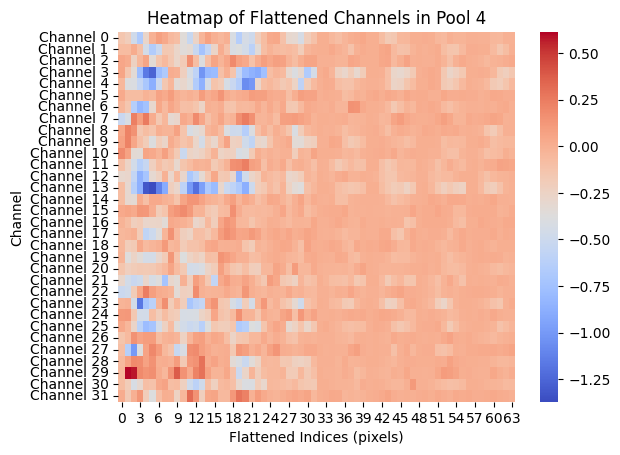

64 64
1


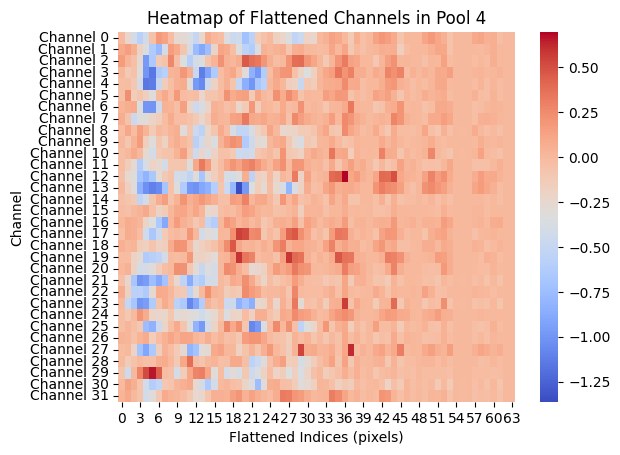

64 64
1


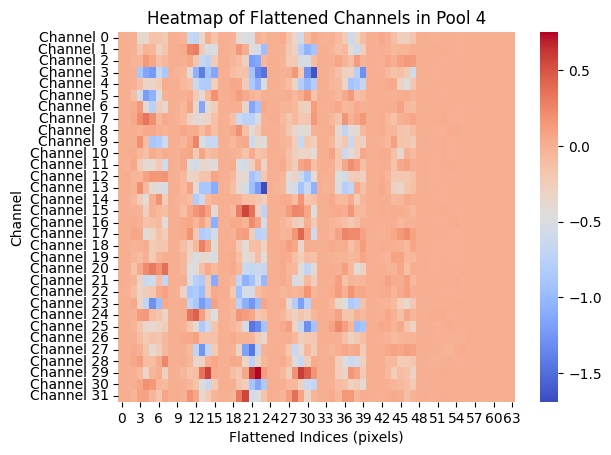

64 64
1


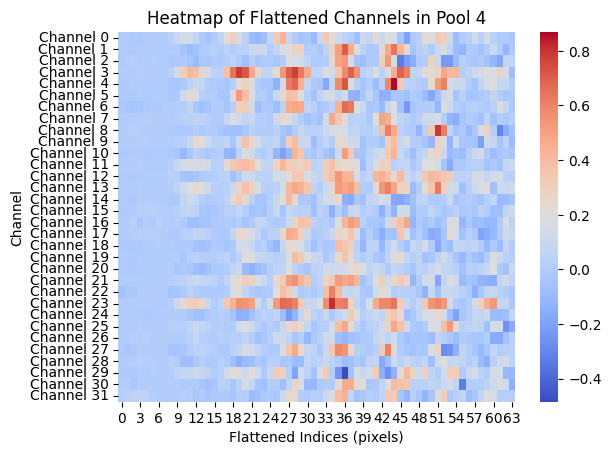

64 64
1


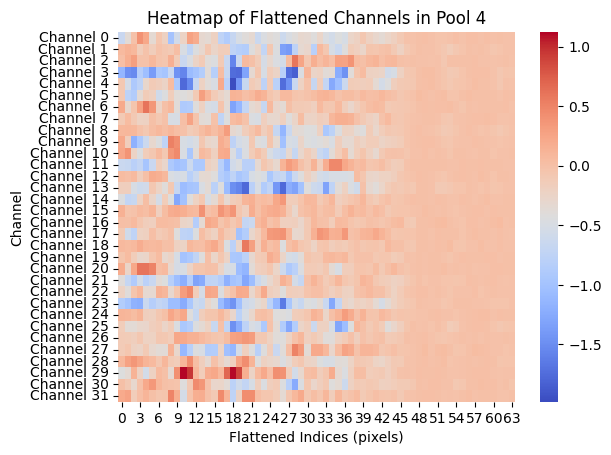

64 64
1


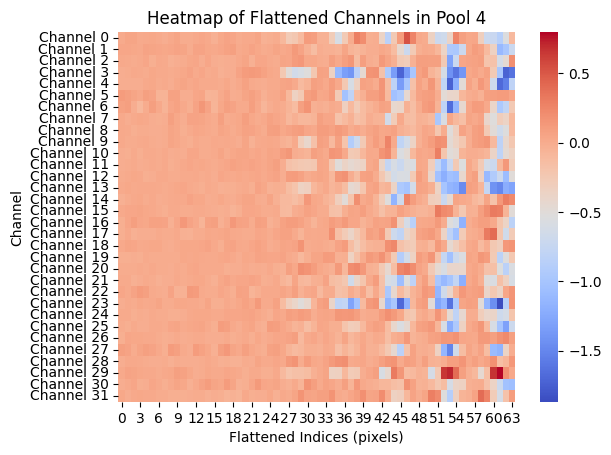

64 64
1


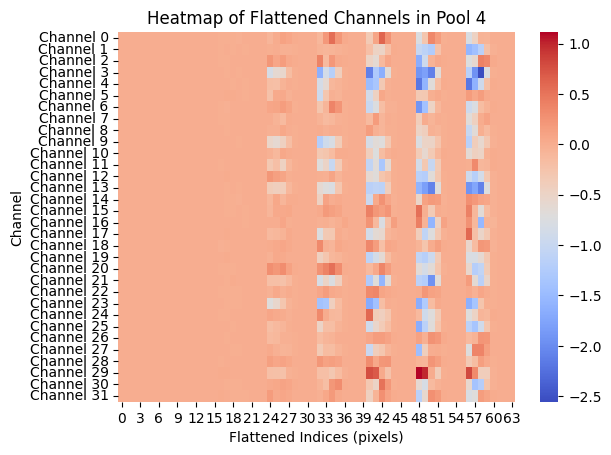

64 64
1


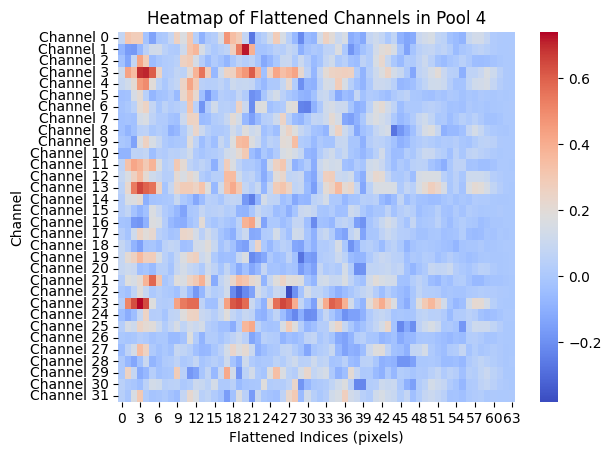

64 64
1


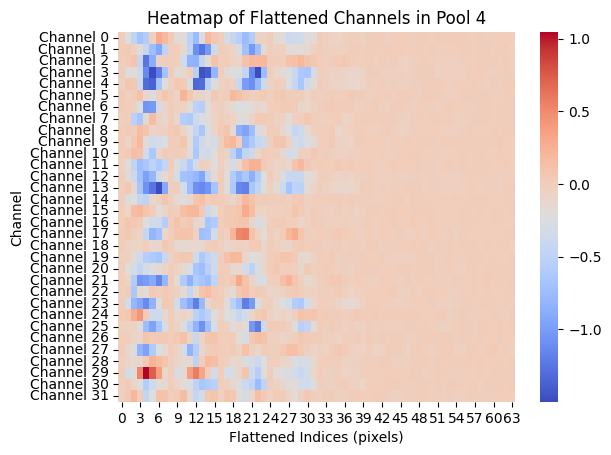

64 64
1


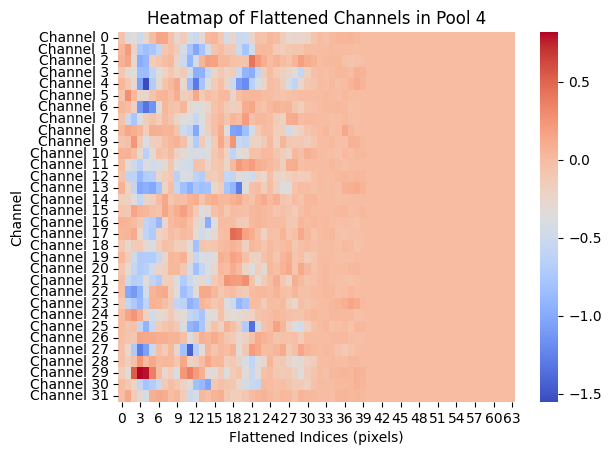

64 64
1


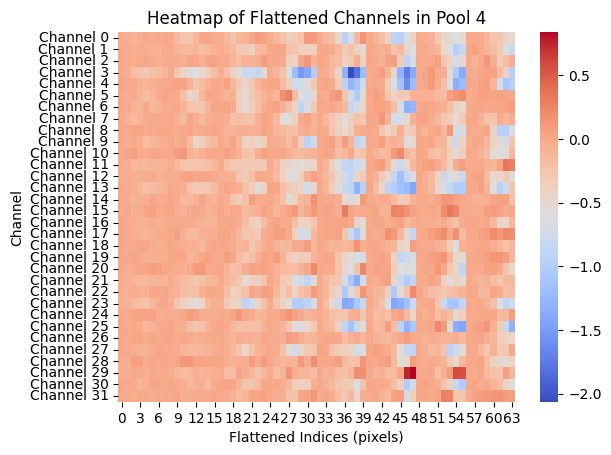

64 64
1


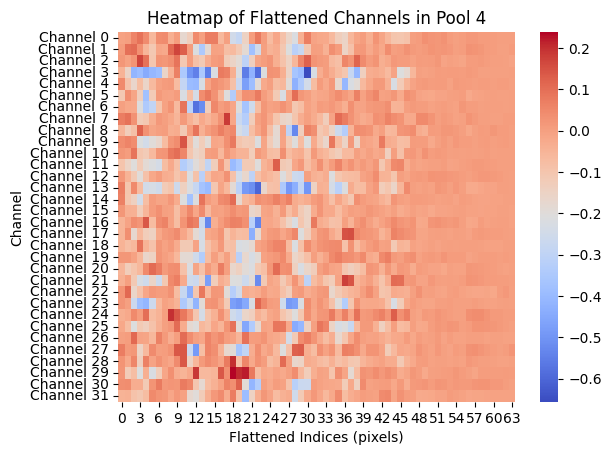

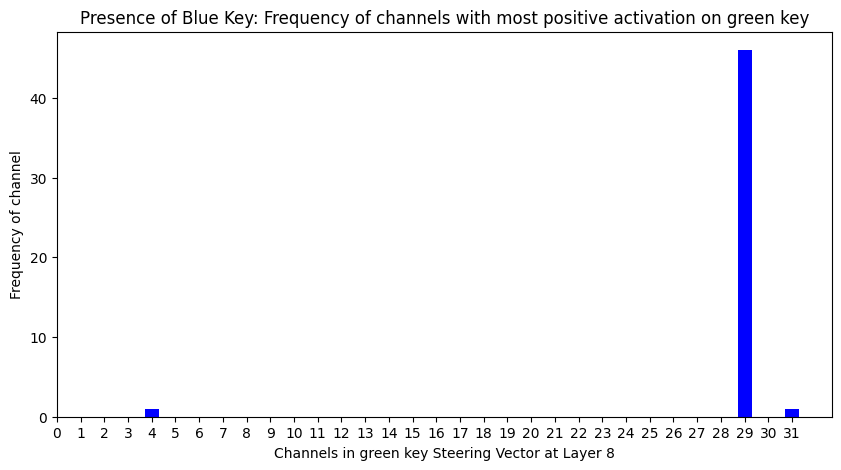

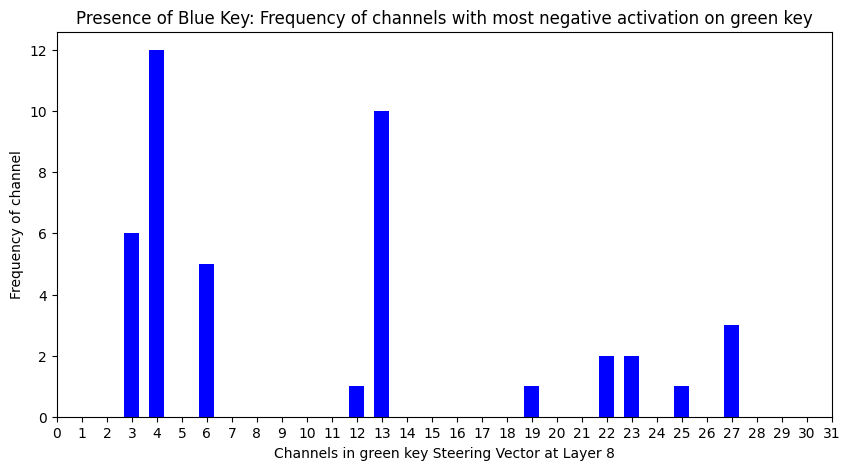

In [17]:
#This diagram is for in the presense of the blue key
for layer_number in range(8,9):
    dataset = get_venvs_objective_steering("key", "green",100)
    from src.utils.steering_experiments import steering_vector
    model_path ="model_interpretable.pt"
    entity_name = "key"
    entity_color = "green"
    max_matrix_indices = {}
    min_matrix_indices = {}
    for i in range(len(dataset)):
        filepath =f"../gifs/dataset{i}"
        venv = dataset[i]
        stv, original_position, _= steering_vector(venv= venv,model_path= model_path,layer_number = layer_number,entity_name=entity_name,entity_color=entity_color, filepath = filepath, save_gif = "False")
        sv= convert_to_list(stv)
        visualize_heatmap(sv)
        matrix_index, _, _ = find_largest_entry_all_layers(sv, original_position)            
        if matrix_index != -1:
            if matrix_index not in max_matrix_indices:
                max_matrix_indices[matrix_index] = 1

            else:
                max_matrix_indices[matrix_index] += 1
        matrix_index, _, _ = find_smallest_entry_all_layers(sv, original_position)            
        if matrix_index != -1:
            if matrix_index not in min_matrix_indices:
                min_matrix_indices[matrix_index] = 1

            else:
                min_matrix_indices[matrix_index] += 1

    print_histogram("Presence of Blue Key: Frequency of channels with most positive activation on green key",max_matrix_indices, layer_number, entity_color + " " + entity_name)
    print_histogram("Presence of Blue Key: Frequency of channels with most negative activation on green key",min_matrix_indices, layer_number, entity_color + " " + entity_name)

64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1


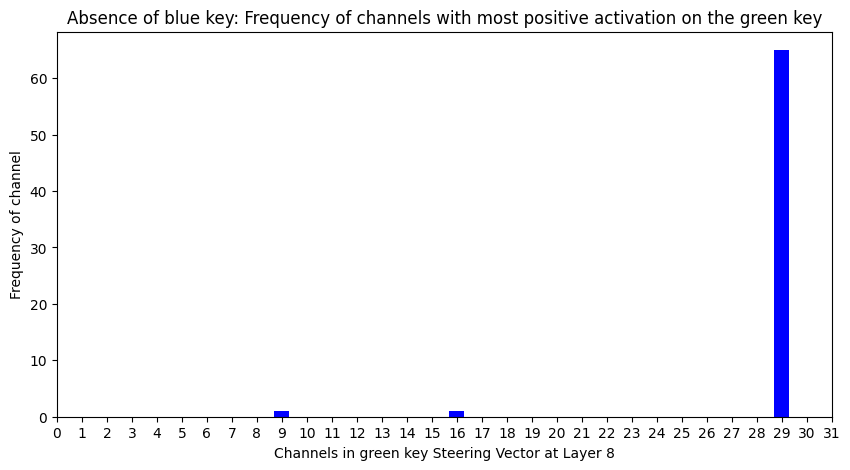

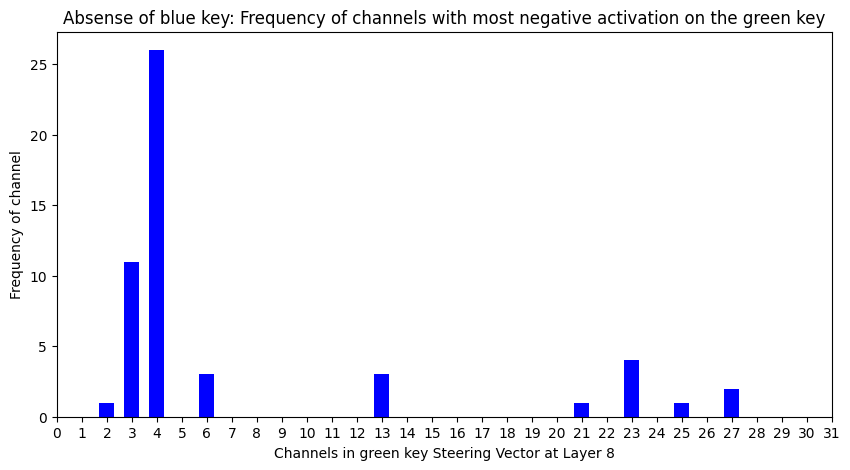

In [18]:
#This is in the absense of the blue key
for layer_number in range(8,9):
    dataset = heist.create_classified_dataset_venvs(100)
    dataset = dataset["green_key"]
    from src.utils.steering_experiments import steering_vector
    model_path ="model_interpretable.pt"
    entity_name = "key"
    entity_color = "green"
    max_matrix_indices = {}
    min_matrix_indices = {}
    for i in range(len(dataset)):
        filepath =f"../gifs/dataset{i}"
        venv = dataset[i]
        stv, original_position,_= steering_vector(venv= venv,model_path= model_path,layer_number = layer_number,entity_name=entity_name,entity_color=entity_color, filepath = filepath, save_gif = "False")
        sv= convert_to_list(stv)
        matrix_index, _, _ = find_largest_entry_all_layers(sv, original_position)            
        if matrix_index != -1:
            if matrix_index not in max_matrix_indices:
                max_matrix_indices[matrix_index] = 1

            else:
                max_matrix_indices[matrix_index] += 1
        matrix_index, _, _ = find_smallest_entry_all_layers(sv, original_position)            
        if matrix_index != -1:
            if matrix_index not in min_matrix_indices:
                min_matrix_indices[matrix_index] = 1

            else:
                min_matrix_indices[matrix_index] += 1

    print_histogram("Absence of blue key: Frequency of channels with most positive activation on the green key",max_matrix_indices, layer_number, entity_color + " " + entity_name)
    print_histogram("Absense of blue key: Frequency of channels with most negative activation on the green key",min_matrix_indices, layer_number, entity_color + " " + entity_name)

64 64
None
64 64
None
64 64
None
64 64
None
64 64
None
64 64
None
64 64
None
64 64
None
64 64
None
64 64
None
64 64
None
64 64
None
64 64
None
64 64
None
64 64
None
64 64
None
64 64
None
64 64
None
64 64
None
64 64
None
64 64
None
64 64
None
64 64
None
64 64
None
64 64
None
64 64
None
64 64
None
64 64
None
64 64
None
64 64
None
64 64
None
64 64
None
64 64
None
64 64
None
64 64
None
64 64
None
64 64
None
64 64
None
64 64
None
64 64
None
64 64
None
64 64
None
64 64
None
64 64
None
64 64
None
64 64
None
64 64
None
64 64
None
64 64
None
64 64
None
64 64
None
64 64
None
64 64
None
64 64
None
64 64
None
64 64
None
64 64
None
64 64
None
64 64
None
64 64
None
64 64
None
64 64
None
64 64
None
64 64
None
64 64
None
64 64
None
64 64
None
64 64
None
64 64
None
64 64
None
64 64
None
64 64
None
64 64
None
64 64
None
64 64
None
64 64
None
64 64
None
64 64
None
64 64
None
64 64
None
64 64
None
64 64
None
64 64
None
64 64
None
64 64
None
64 64
None
64 64
None
64 64
None
64 64
None
64 64
None
64 64
None

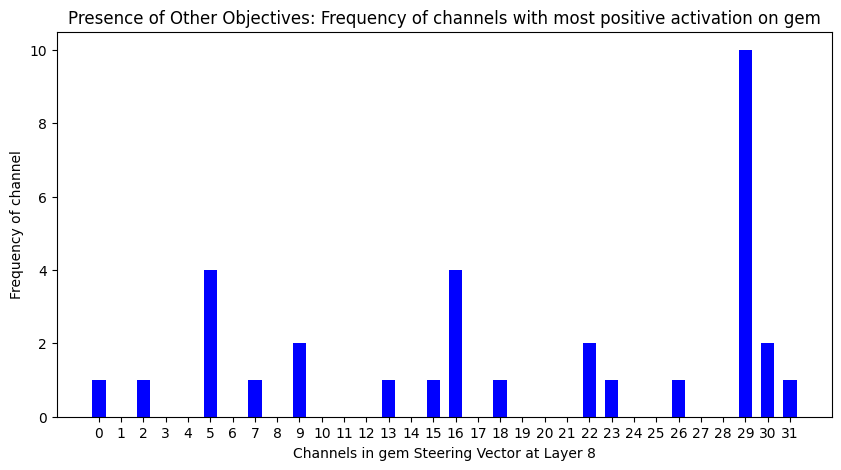

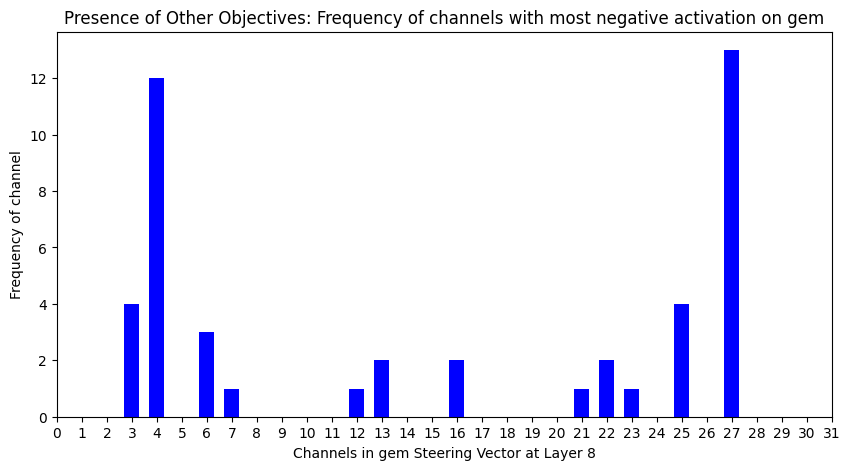

In [9]:
#This diagram is for in the presense of the other keys
for layer_number in range(8,9):
    from src.utils.steering_experiments import steering_vector
    model_path ="model_interpretable.pt"
    entity_name = "gem"
    entity_color = None
    max_matrix_indices = {}
    min_matrix_indices = {}
    for i in range(100):
        filepath =f"../gifs/dataset{i}"
        start_level = random.randint(100000, 100000000)
        venv = heist.create_venv(num=1, num_levels=0, start_level=start_level)
        stv, original_position, _= steering_vector(venv= venv,model_path= model_path,layer_number = layer_number,entity_name=entity_name,entity_color=entity_color, filepath = filepath, save_gif = "False")
        sv= convert_to_list(stv)
        matrix_index, _, _ = find_largest_entry_all_layers(sv, original_position)            
        if matrix_index != -1:
            if matrix_index not in max_matrix_indices:
                max_matrix_indices[matrix_index] = 1

            else:
                max_matrix_indices[matrix_index] += 1
        matrix_index, _, _ = find_smallest_entry_all_layers(sv, original_position)            
        if matrix_index != -1:
            if matrix_index not in min_matrix_indices:
                min_matrix_indices[matrix_index] = 1

            else:
                min_matrix_indices[matrix_index] += 1
    print(min_matrix_indices)
    print_histogram("Presence of Other Objectives: Frequency of channels with most positive activation on gem",max_matrix_indices, layer_number,  entity_name)
    print_histogram("Presence of Other Objectives: Frequency of channels with most negative activation on gem",min_matrix_indices, layer_number, entity_name)

64 64
None
64 64
None
64 64
None
64 64
None
64 64
None
64 64
None
64 64
None
64 64
None
64 64
None
64 64
None
64 64
None
64 64
None
64 64
None
64 64
None
64 64
None
64 64
None
64 64
None
64 64
None
64 64
None
64 64
None
64 64
None
64 64
None
64 64
None
64 64
None
64 64
None
64 64
None
64 64
None
64 64
None
64 64
None
64 64
None
64 64
None
64 64
None
64 64
None
64 64
None
64 64
None
64 64
None
64 64
None
64 64
None
64 64
None
64 64
None
64 64
None
64 64
None
64 64
None
64 64
None
64 64
None
64 64
None
64 64
None
64 64
None
64 64
None
64 64
None
64 64
None
64 64
None
64 64
None
64 64
None
64 64
None
64 64
None
64 64
None
64 64
None
64 64
None
64 64
None
64 64
None
64 64
None
64 64
None
64 64
None
64 64
None
64 64
None
64 64
None
64 64
None
64 64
None
64 64
None
64 64
None
64 64
None
64 64
None
64 64
None
64 64
None
64 64
None
64 64
None
64 64
None
64 64
None
64 64
None
64 64
None
64 64
None
64 64
None
64 64
None
64 64
None
64 64
None
64 64
None
64 64
None
64 64
None
64 64
None
64 64
None

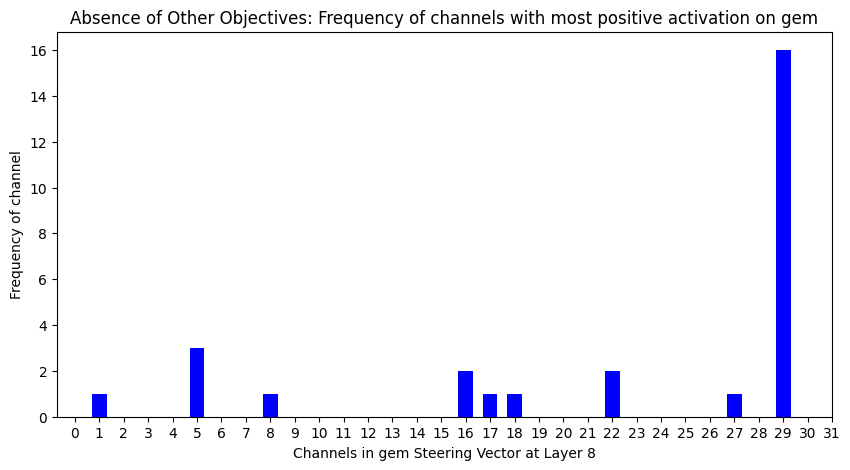

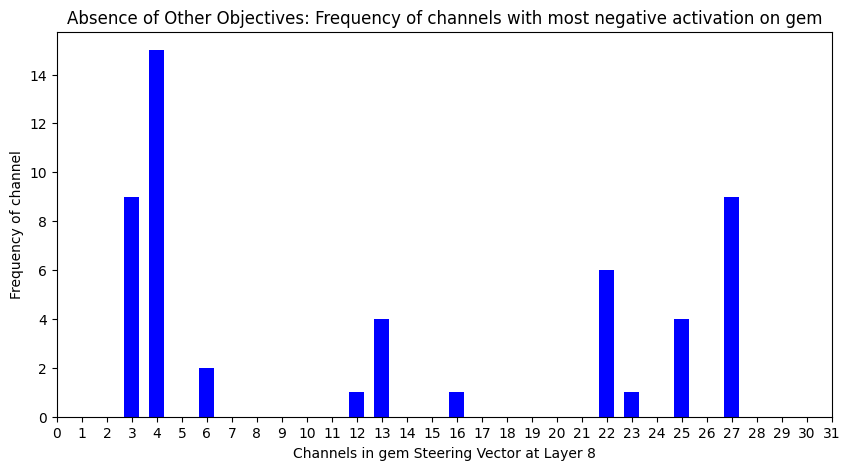

In [10]:
for layer_number in range(8,9):
    dataset = heist.create_classified_dataset_venvs(100)
    dataset = dataset["gem"]
    from src.utils.steering_experiments import steering_vector
    model_path ="model_interpretable.pt"
    entity_name = "gem"
    entity_color = None
    max_matrix_indices = {}
    min_matrix_indices = {}
    for i in range(len(dataset)):
        filepath =f"../gifs/dataset{i}"
        venv = dataset[i]
        stv, original_position, _= steering_vector(venv= venv,model_path= model_path,layer_number = layer_number,entity_name=entity_name,entity_color=entity_color, filepath = filepath, save_gif = "False")
        sv= convert_to_list(stv)
        matrix_index, _, _ = find_largest_entry_all_layers(sv, original_position)            
        if matrix_index != -1:
            if matrix_index not in max_matrix_indices:
                max_matrix_indices[matrix_index] = 1

            else:
                max_matrix_indices[matrix_index] += 1
        matrix_index, _, _ = find_smallest_entry_all_layers(sv, original_position)            
        if matrix_index != -1:
            if matrix_index not in min_matrix_indices:
                min_matrix_indices[matrix_index] = 1

            else:
                min_matrix_indices[matrix_index] += 1

    print_histogram("Absence of Other Objectives: Frequency of channels with most positive activation on gem",max_matrix_indices, layer_number, entity_name)
    print_histogram("Absence of Other Objectives: Frequency of channels with most negative activation on gem",min_matrix_indices, layer_number, entity_name)

64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1
64 64
1


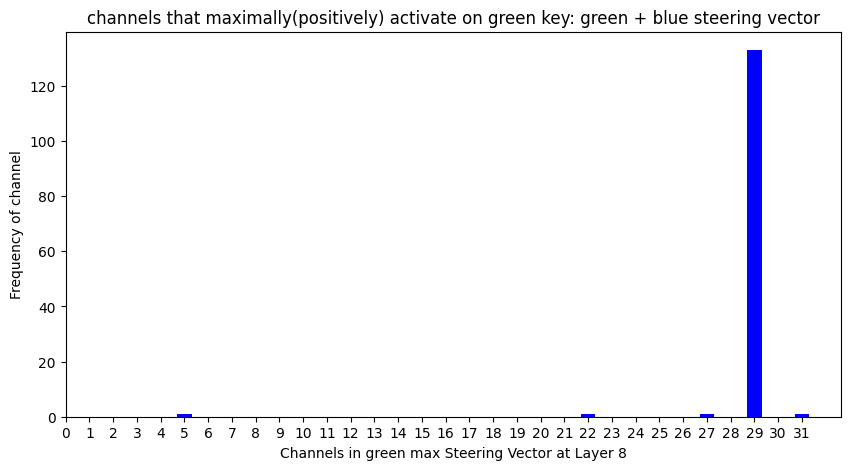

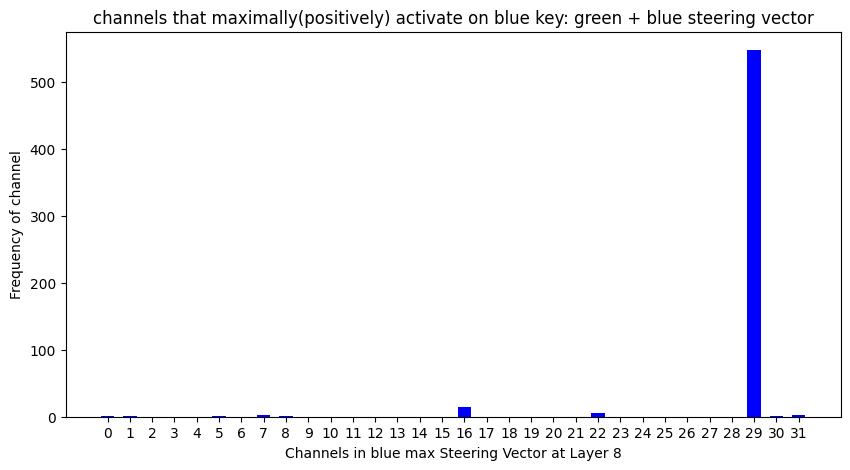

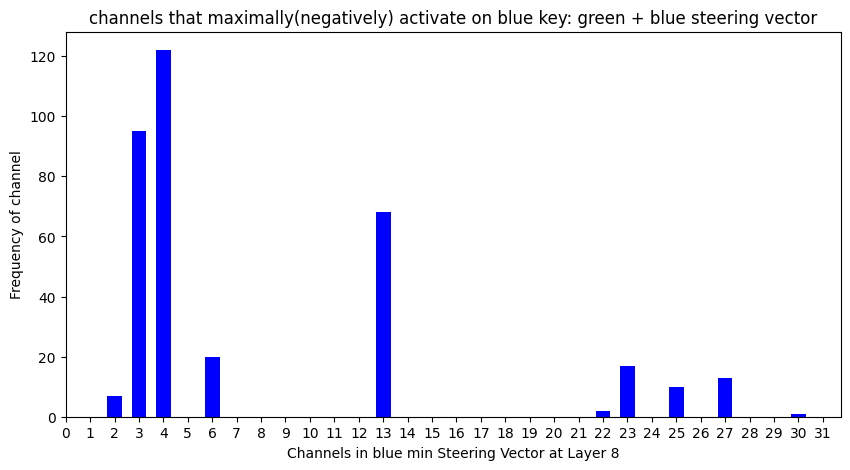

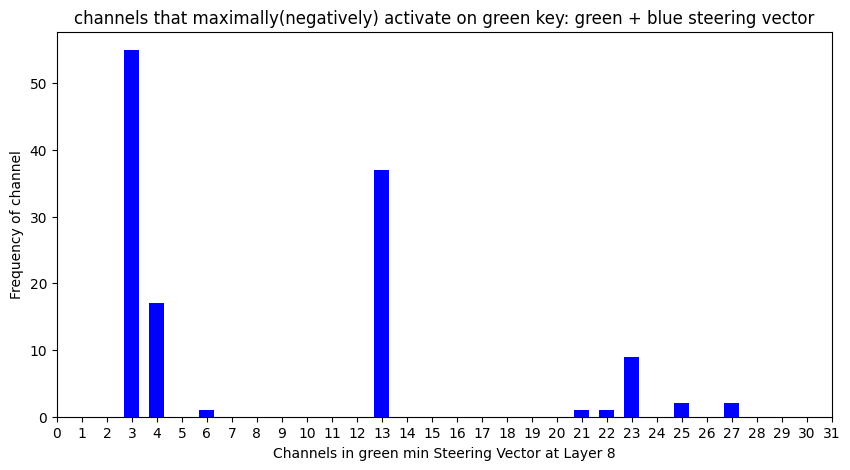

In [10]:
for layer_number in range(8,9):
    dataset = get_venvs_objective_steering("key", "green",1000)
    from src.utils.steering_experiments import green_blue_steering_vector
    model_path ="model_interpretable.pt"
    entity_name = "key"
    entity_color = "green"
    green_max_matrix_indices = {}
    blue_max_matrix_indices = {}
    green_min_matrix_indices = {}
    blue_min_matrix_indices = {}
    for i in range(len(dataset)):
        filepath =f"../gifs/dataset{i}"
        venv = dataset[i]
        stv, original_position, blue_key_position = green_blue_steering_vector(venv= venv,model_path= model_path,layer_number = layer_number,entity_name=entity_name,entity_color=entity_color, filepath = filepath, save_gif = "False")
        sv= convert_to_list(stv)
        green_min_matrix_index, _,_  = find_smallest_entry_all_layers(sv, original_position)
        blue_min_matrix_index, _,_  = find_smallest_entry_all_layers(sv, blue_key_position)    
        green_max_matrix_index, _,_  = find_largest_entry_all_layers(sv, original_position)  
        blue_max_matrix_index, _, _ = find_largest_entry_all_layers(sv,blue_key_position)  

        if green_min_matrix_index != -1:   
            if green_min_matrix_index not in green_min_matrix_indices:
                green_min_matrix_indices[green_min_matrix_index] = 1
            else:
                green_min_matrix_indices[green_min_matrix_index] += 1

        if green_max_matrix_index != -1:    
            if green_max_matrix_index not in green_max_matrix_indices:
                green_max_matrix_indices[green_max_matrix_index] = 1
            else:
                green_max_matrix_indices[green_max_matrix_index] += 1
        if blue_min_matrix_index != -1:   
            if blue_min_matrix_index not in blue_min_matrix_indices:
                blue_min_matrix_indices[blue_min_matrix_index] = 1
            else:
                blue_min_matrix_indices[blue_min_matrix_index] += 1

        if blue_max_matrix_index != -1:    
            if blue_max_matrix_index not in blue_max_matrix_indices:
                blue_max_matrix_indices[blue_max_matrix_index] = 1
            else:
                blue_max_matrix_indices[blue_max_matrix_index] += 1


    print_histogram("channels that maximally(positively) activate on green key: green + blue steering vector", green_max_matrix_indices, layer_number, "green max")
    print_histogram("channels that maximally(positively) activate on blue key: green + blue steering vector", blue_max_matrix_indices, layer_number, "blue max")
    print_histogram("channels that maximally(negatively) activate on blue key: green + blue steering vector", blue_min_matrix_indices, layer_number, "blue min")
    print_histogram("channels that maximally(negatively) activate on green key: green + blue steering vector", green_min_matrix_indices, layer_number, "green min")
    